以下のパラメータでシミュレーションを実行した結果。

```
trial_count = 20
agent_count = 10^3
generations = 10^3

network_type_list = [:scale_free_4, :scale_free_6, :scale_free_8, :regular_4, :random_4]
weak_selection_list = [true, false]
calc_payoffs_pattern_list = [1, 2, 3]
hop_game_list = [1, 2, 3, 4, 5]
hop_learning_list = [1, 2, 3, 4, 5]
b_list = [2.0, 3.0, 4.0, 5.0]
μ_list = [0.00, 0.01]
δ_list = [0.1, 0.3, 0.5, 0.7, 0.9]
```

とりあえず、このノートでは hopG ≧ 2 の場合に見るべきものがないことだけ確認して、hopG = 1 の場合については、hopG_1.iphnb で確認する。

In [1]:
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.0, style = 'darkgrid')

In [24]:
COLUMNS = ['network_type', 'weak_selection', 'calc_pattern', 'hop_game', 'hop_learning', 'b', 'μ', 'δ', 'trial', 'step', 'cooperator_rate']

def load_df_all(csv_file_name: str) -> pd.DataFrame:
    dtype = {i: 'category' for i in range(len(COLUMNS))}
    dtype[len(COLUMNS) - 2] = 'int'
    dtype[len(COLUMNS) - 1] = 'float64'
    return pd.read_csv(csv_file_name, header=None, names=COLUMNS, dtype=dtype)

def filter_by_network_hop_n_b(
    df: pd.DataFrame, network_type:str, hop_games:list, hop_learnings: list, bs: list
) -> pd.DataFrame:
    return df[
        (df.network_type == network_type) &
        (df.hop_game.isin(hop_games)) &
        (df.hop_learning.isin(hop_learnings)) &
        (df.b.isin(bs))
    ][[
        'hop_game', 'hop_learning', 'b', 'trial', 'step', 'cooperator_rate'
    ]].reset_index(drop=True)

def filter_by_step(df: pd.DataFrame, step:int) -> pd.DataFrame:
    return df[df.step >= step].reset_index(drop=True)

def filter_by_criteria(df: pd.DataFrame, network_type: str = None, μ: float = None, calc_pattern: int = None) -> pd.DataFrame:
    return df[
        (df.network_type == network_type) &
        (df.μ == μ) &
        (df.calc_pattern == calc_pattern)
    ][[
        'hop_game', 'hop_learning', 'b', 'δ', 'cooperator_rate'
    ]].reset_index(drop=True)

def mean_by_hop_b(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby([
        'hop_game', 'hop_learning', 'b'
    ]).agg({
        'cooperator_rate': np.mean
    }).reset_index(drop=True)

def mean_by_trial_step(df: pd.DataFrame) -> pd.DataFrame:
    groupby_columns = [c for c in COLUMNS if c not in ['trial', 'step', 'cooperator_rate']]
    return df.groupby(groupby_columns).agg({'cooperator_rate': np.mean}).reset_index()
    
def transform_for_heatmaps(df: pd.DataFrame, network_type: str) -> pd.DataFrame:
    _df = filter_by_network_hop_n_b(df, network_type, [1, 2, 3, 4, 5], [1, 2, 3, 4, 5], 4, 4, [2, 3])
    _df = filter_by_step(_df, 800)
    _df = mean_by_hop_b(_df)
    _df['cooperator_rate'] = _df['cooperator_rate'] * 100
    return _df

def pibot_by_hop(df: pd.DataFrame) -> pd.DataFrame:
    return pd.pivot_table(
        data=df,
        values='cooperator_rate',
        columns='hop_learning',
        index='hop_game',
        aggfunc=np.mean
    ).sort_index(level=0, ascending=False, inplace=False)

def draw_heatmaps(df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    for x, b in enumerate(set(df.b)):
        _df = pibot_by_hop(df[df.b == b])
        sns.heatmap(_df, annot=True, fmt='.1f', cmap='Blues', vmin=0, vmax=100, cbar=False, ax=axes[x])
        axes[x].set_xlabel('hopL')
        axes[x].set_ylabel('hopG')
        # plt.savefig('img/draw_heatmaps_b{}.png'.format(b), dpi = 300)

def draw_lines(df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    fig.suptitle('Transition of population frequency', fontsize=15)

    for x, b in enumerate(set(df.b)):
        _df = df[df.b == b]
        axes[x].set_title('b = {}'.format(b))
        axes[x].set_xlim(0, 1000)
        axes[x].set_ylim(0, 1)
        axes[x].set_ylabel('Population frequency of cooperators')
        palette = sns.color_palette('hls', len(set(df.hop_learning)))
        sns.lineplot(data=_df, x='step', y='cooperator_rate', hue='hop_learning', palette=palette, ax=axes[x])
        # plt.savefig('img/draw_lines_b{}.png'.format(b), dpi = 300)
        
def show(csv_file_name: str):
    df = load_df_all(csv_file_name)
    df_last200 = transform_for_heatmaps(df, 'scale_free_4')
    df_learning = filter_by_network_hop_n_b(df, 'scale_free_4', [1], [1, 2, 3, 4, 5], 4, 4, [2, 3])
    draw_heatmaps(df_last200)
    draw_lines(df_learning)

In [3]:
df_list = [load_df_all('data/20220501_185340/{}.csv'.format(csv)) for csv in range(1, 21)]
df = pd.concat(df_list)
print(df.shape)
df = filter_by_step(df, 800)
df = mean_by_trial_step(df)
df

(24600000, 11)


,network_type,weak_selection,calc_pattern,hop_game,hop_learning,b,μ,δ,cooperator_rate
0,random_4,false,1,1,1,2.0,0.0,0.1,0.000300
1,random_4,false,1,1,1,2.0,0.0,0.3,0.000200
2,random_4,false,1,1,1,2.0,0.0,0.5,0.000300
3,random_4,false,1,1,1,2.0,0.0,0.7,0.000950
4,random_4,false,1,1,1,2.0,0.0,0.9,0.000000
...,...,...,...,...,...,...,...,...,...
29995,scale_free_8,true,3,5,5,5.0,0.01,0.1,0.044683
29996,scale_free_8,true,3,5,5,5.0,0.01,0.3,0.010994
29997,scale_free_8,true,3,5,5,5.0,0.01,0.5,0.000228
29998,scale_free_8,true,3,5,5,5.0,0.01,0.7,0.000000


In [16]:
df_weak_selection = df[df.weak_selection == 'true'][[c for c in COLUMNS if c not in ['weak_selection', 'trial', 'step']]]
df_weak_selection

,network_type,calc_pattern,hop_game,hop_learning,b,μ,δ,cooperator_rate
3000,random_4,1,1,1,2.0,0.0,0.1,0.000000
3001,random_4,1,1,1,2.0,0.0,0.3,0.000000
3002,random_4,1,1,1,2.0,0.0,0.5,0.000000
3003,random_4,1,1,1,2.0,0.0,0.7,0.000000
3004,random_4,1,1,1,2.0,0.0,0.9,0.000000
...,...,...,...,...,...,...,...,...
29995,scale_free_8,3,5,5,5.0,0.01,0.1,0.044683
29996,scale_free_8,3,5,5,5.0,0.01,0.3,0.010994
29997,scale_free_8,3,5,5,5.0,0.01,0.5,0.000228
29998,scale_free_8,3,5,5,5.0,0.01,0.7,0.000000


In [23]:
df_best_selection = df[df.weak_selection == 'false'][[c for c in COLUMNS if c not in ['weak_selection', 'δ', 'trial', 'step']]]
groupby_columns = [c for c in COLUMNS if c not in ['weak_selection', 'δ', 'trial', 'step', 'cooperator_rate']]
df_best_selection =  df_best_selection.groupby(groupby_columns).agg({'cooperator_rate': np.mean}).reset_index()
df_best_selection

,network_type,calc_pattern,hop_game,hop_learning,b,μ,cooperator_rate
0,random_4,1,1,1,2.0,0.0,0.000350
1,random_4,1,1,1,2.0,0.01,0.000021
2,random_4,1,1,1,3.0,0.0,0.036706
3,random_4,1,1,1,3.0,0.01,0.000163
4,random_4,1,1,1,4.0,0.0,0.826438
...,...,...,...,...,...,...,...
2995,scale_free_8,3,5,5,3.0,0.01,0.000009
2996,scale_free_8,3,5,5,4.0,0.0,0.000000
2997,scale_free_8,3,5,5,4.0,0.01,0.000000
2998,scale_free_8,3,5,5,5.0,0.0,0.000000


network_type: random_4, μ: 0.0, calc_pattern: 1
network_type: random_4, μ: 0.01, calc_pattern: 1
network_type: random_4, μ: 0.0, calc_pattern: 2
network_type: random_4, μ: 0.01, calc_pattern: 2
network_type: random_4, μ: 0.0, calc_pattern: 3
network_type: random_4, μ: 0.01, calc_pattern: 3
network_type: regular_4, μ: 0.0, calc_pattern: 1
network_type: regular_4, μ: 0.01, calc_pattern: 1
network_type: regular_4, μ: 0.0, calc_pattern: 2
network_type: regular_4, μ: 0.01, calc_pattern: 2
network_type: regular_4, μ: 0.0, calc_pattern: 3
network_type: regular_4, μ: 0.01, calc_pattern: 3
network_type: scale_free_4, μ: 0.0, calc_pattern: 1
network_type: scale_free_4, μ: 0.01, calc_pattern: 1
network_type: scale_free_4, μ: 0.0, calc_pattern: 2
network_type: scale_free_4, μ: 0.01, calc_pattern: 2
network_type: scale_free_4, μ: 0.0, calc_pattern: 3
network_type: scale_free_4, μ: 0.01, calc_pattern: 3
network_type: scale_free_6, μ: 0.0, calc_pattern: 1
network_type: scale_free_6, μ: 0.01, calc_pat

/var/folders/p1/637brbmn7c39lv4lj085k_8h0000gn/T/ipykernel_7489/3701889283.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=len(δ_list), ncols=len(b_list), figsize=(16, 16))


network_type: scale_free_6, μ: 0.0, calc_pattern: 2
network_type: scale_free_6, μ: 0.01, calc_pattern: 2
network_type: scale_free_6, μ: 0.0, calc_pattern: 3
network_type: scale_free_6, μ: 0.01, calc_pattern: 3
network_type: scale_free_8, μ: 0.0, calc_pattern: 1
network_type: scale_free_8, μ: 0.01, calc_pattern: 1
network_type: scale_free_8, μ: 0.0, calc_pattern: 2
network_type: scale_free_8, μ: 0.01, calc_pattern: 2
network_type: scale_free_8, μ: 0.0, calc_pattern: 3
network_type: scale_free_8, μ: 0.01, calc_pattern: 3


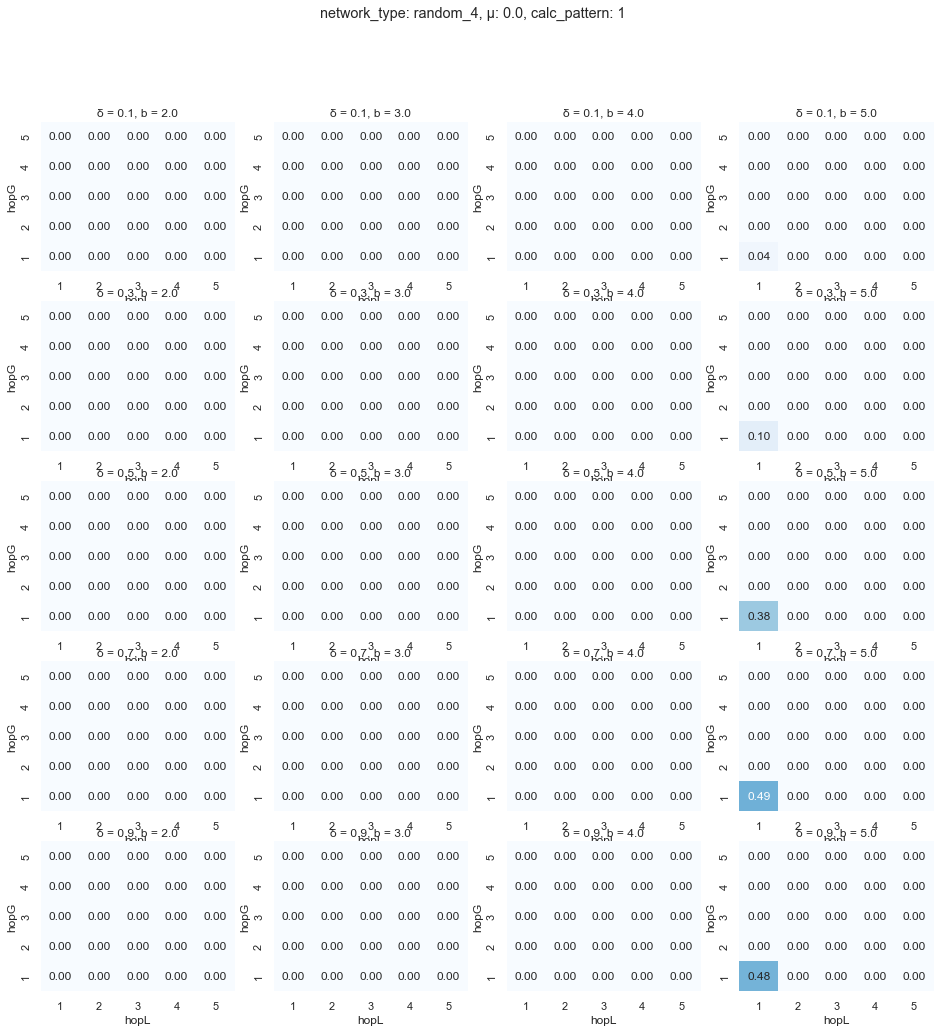

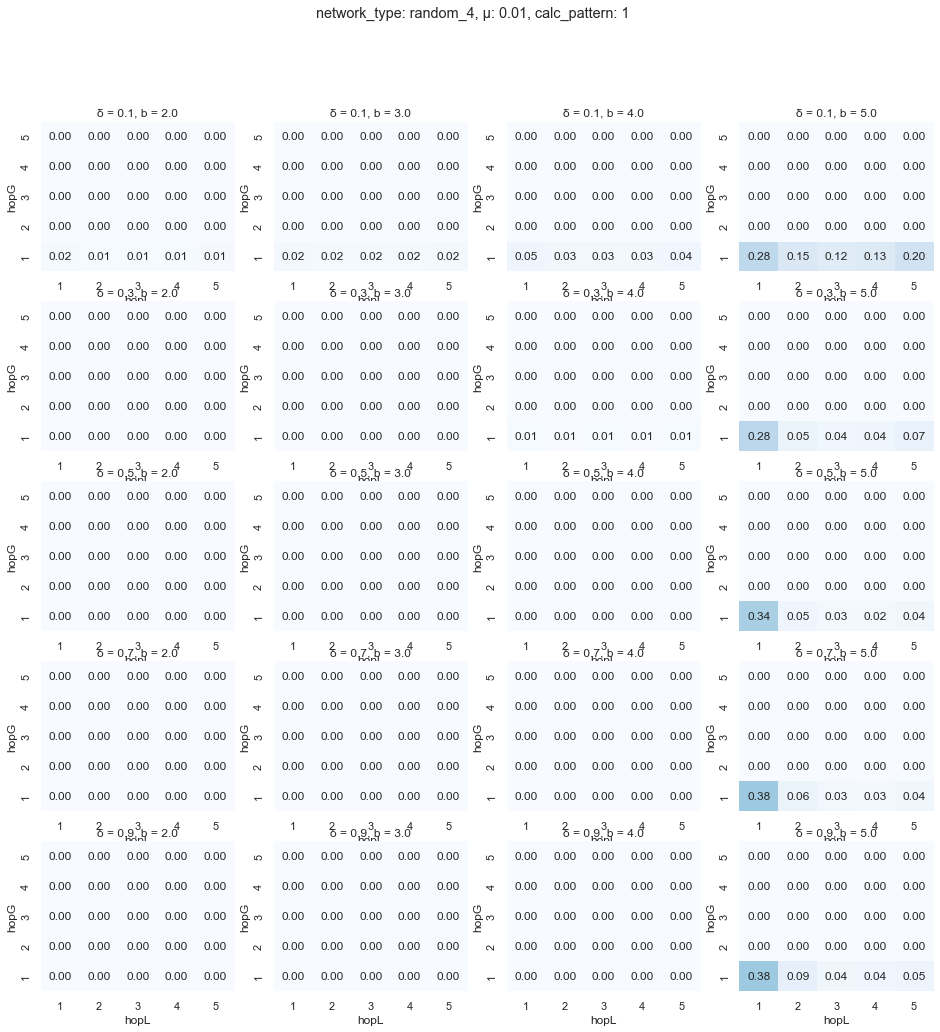

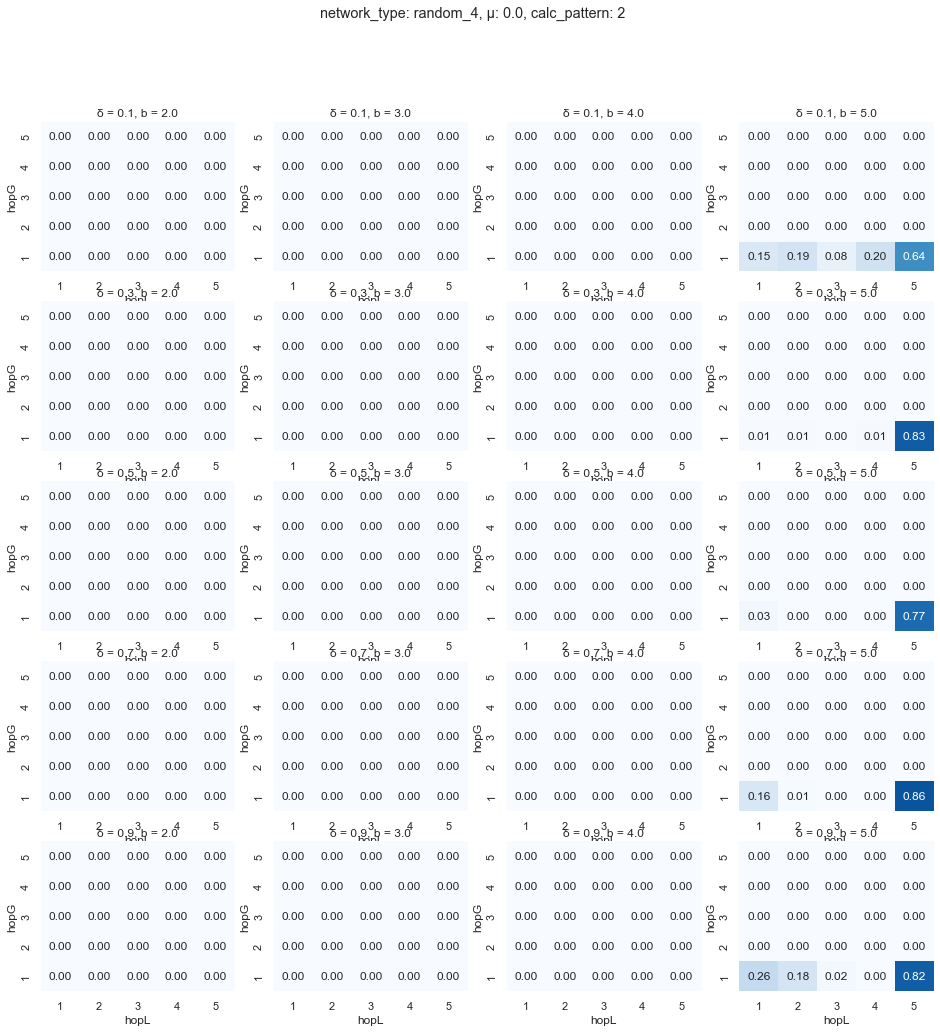

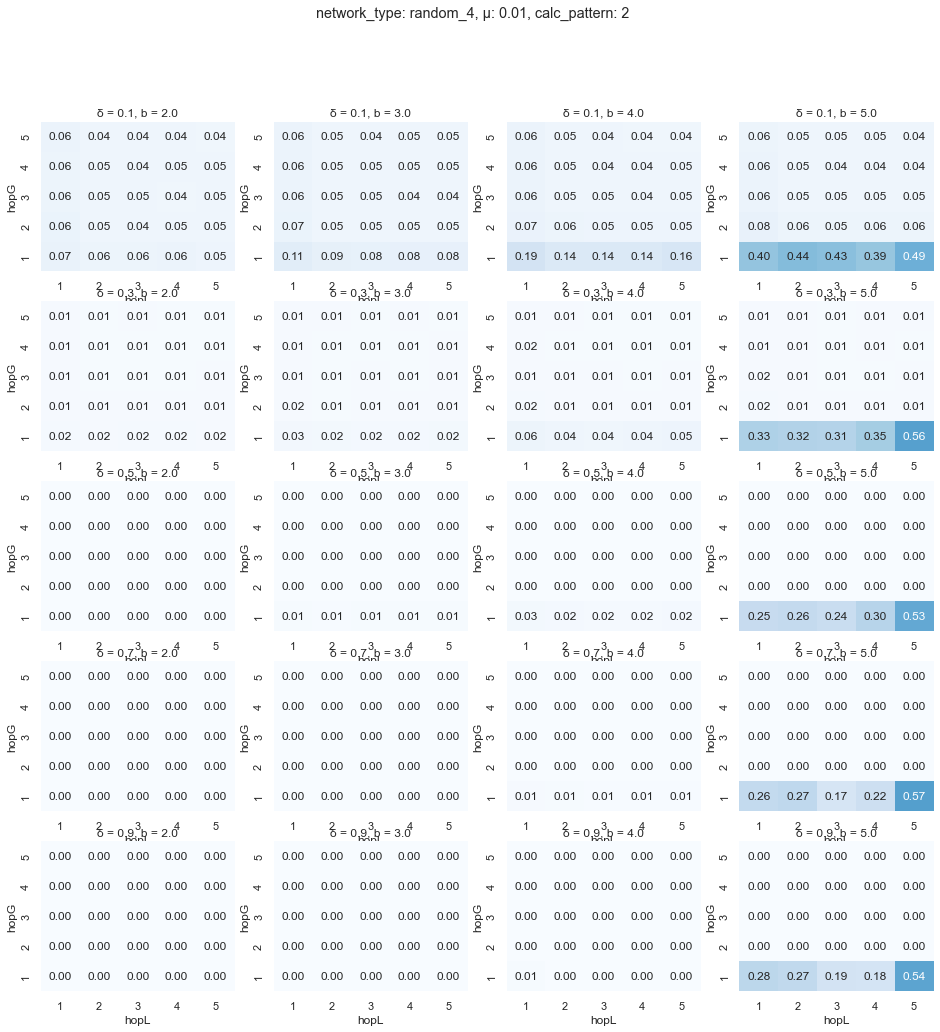

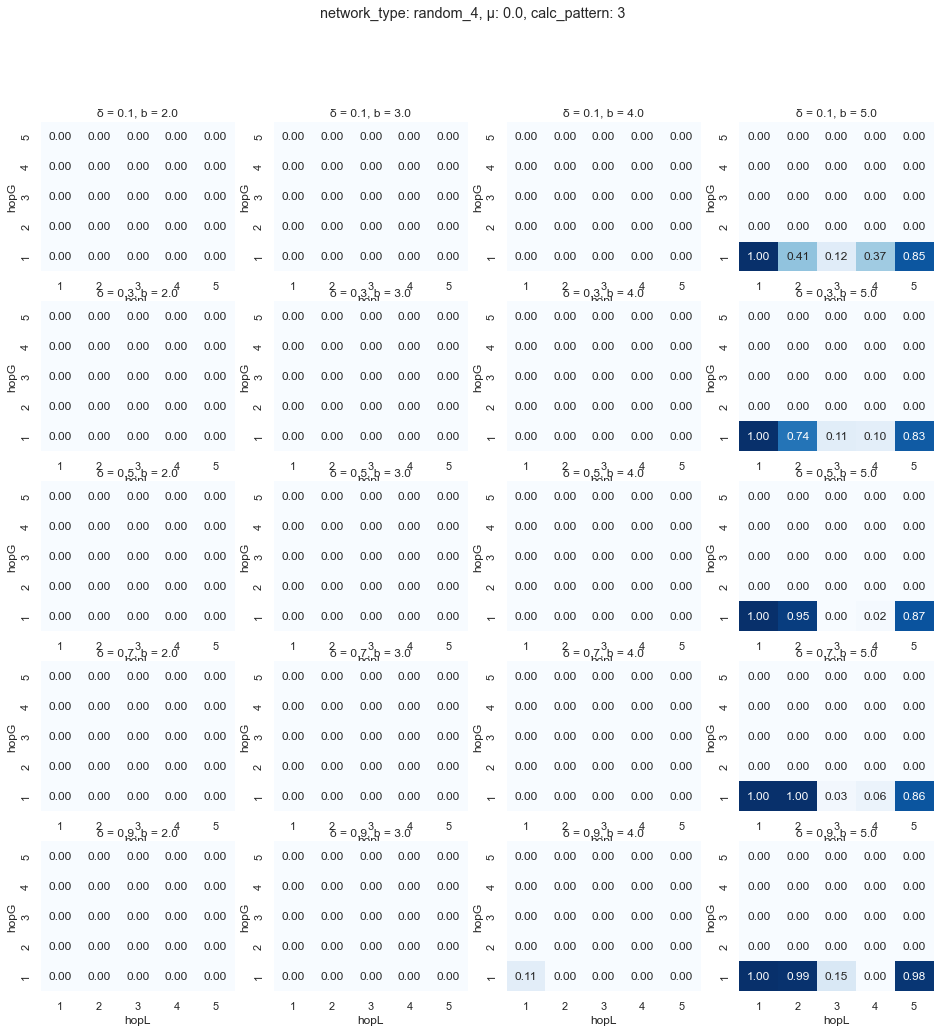

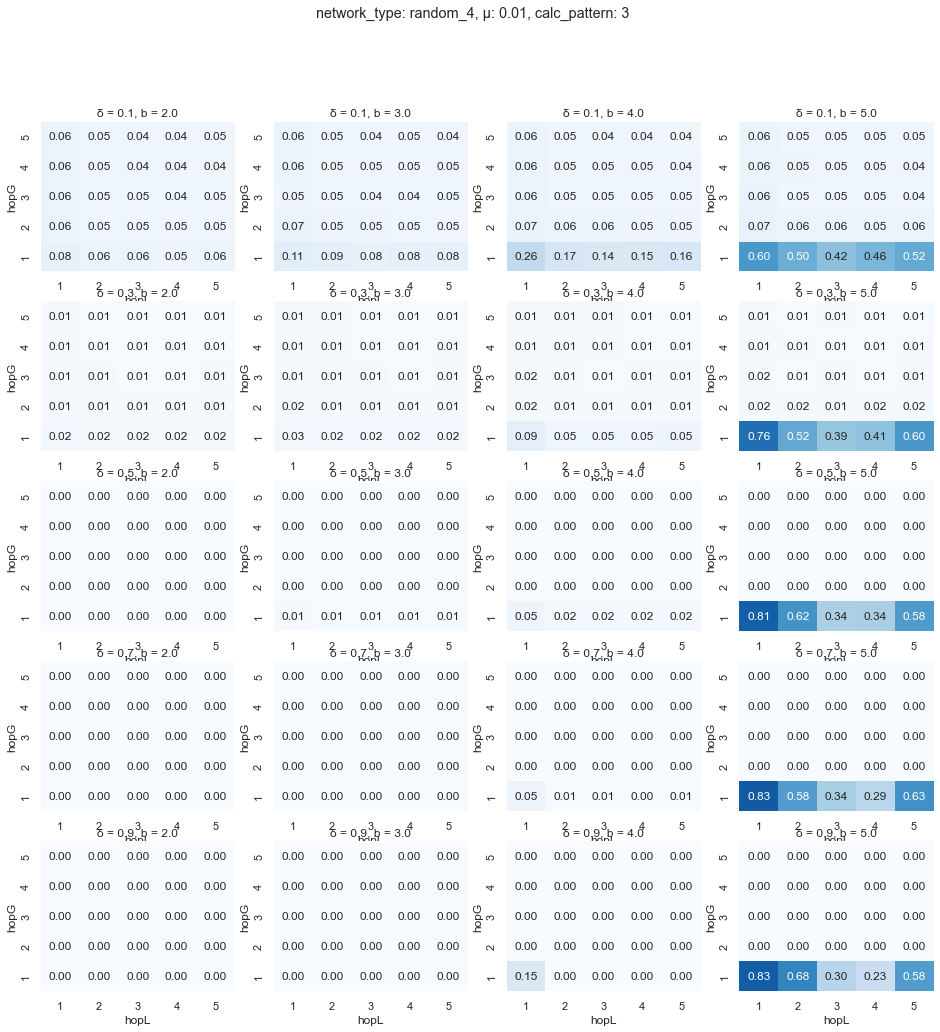

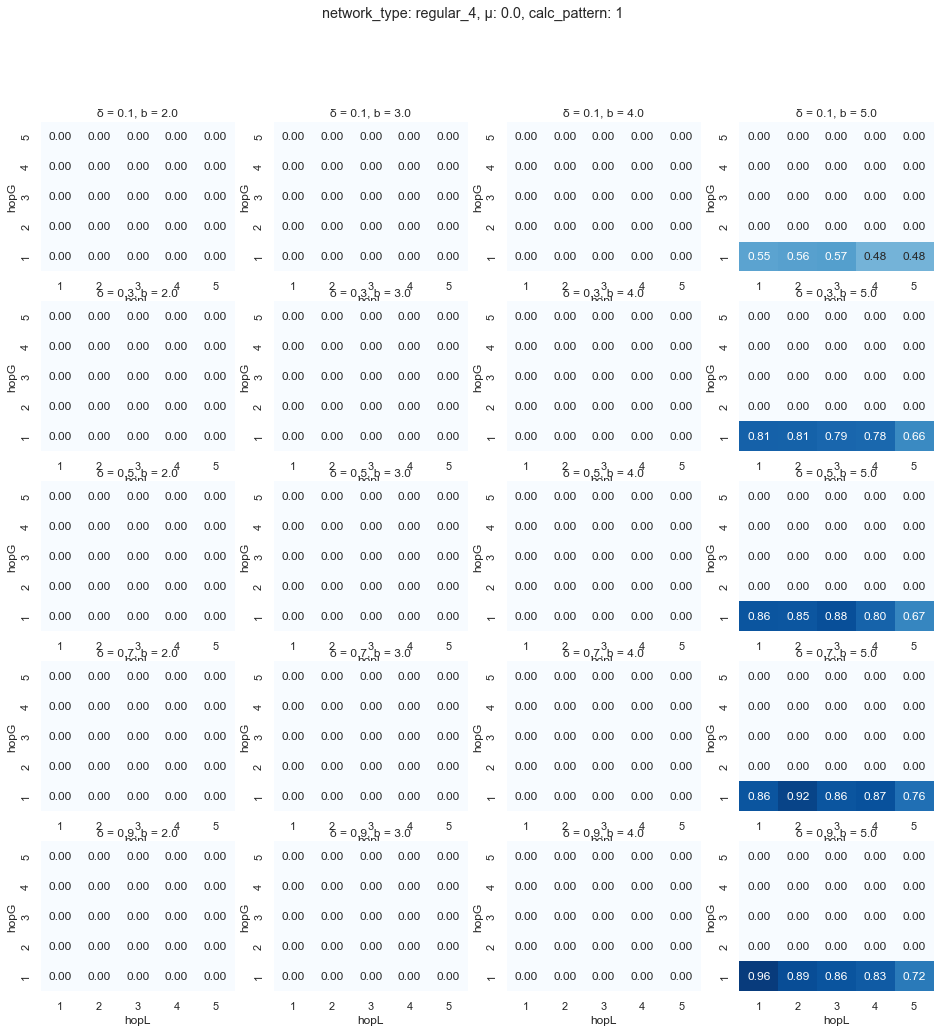

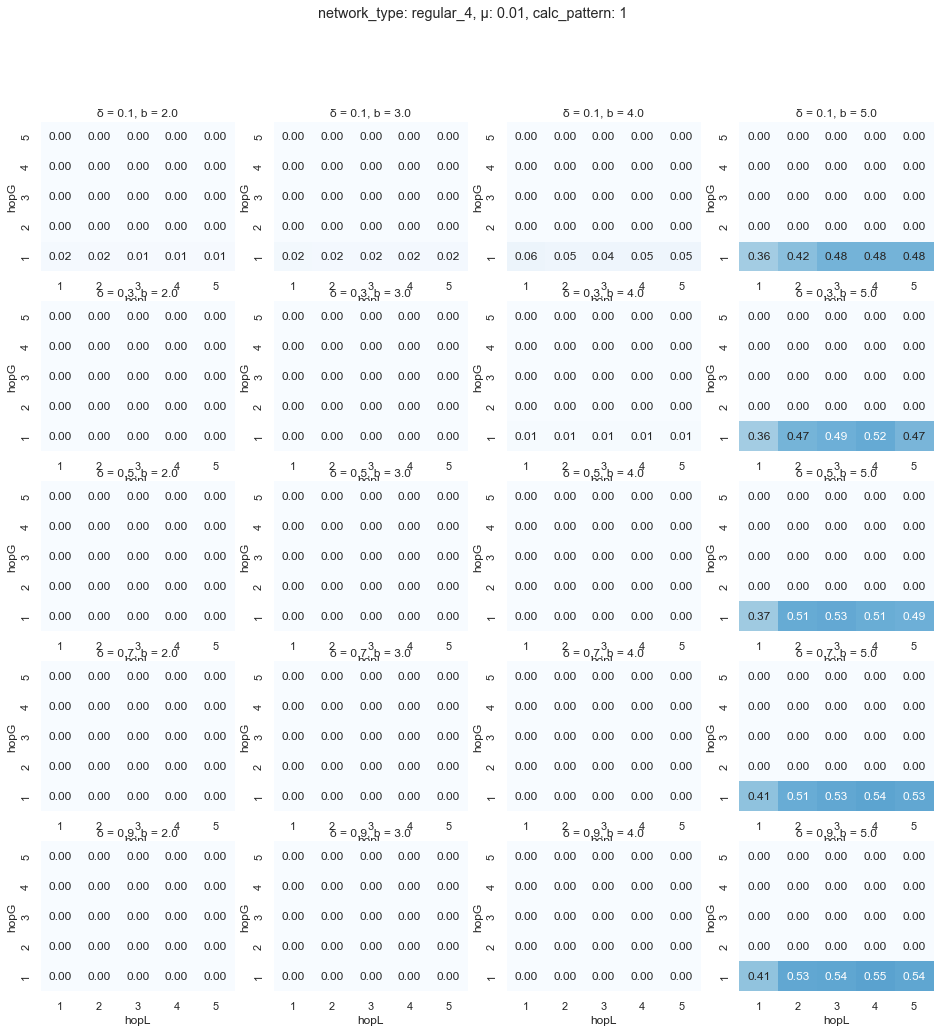

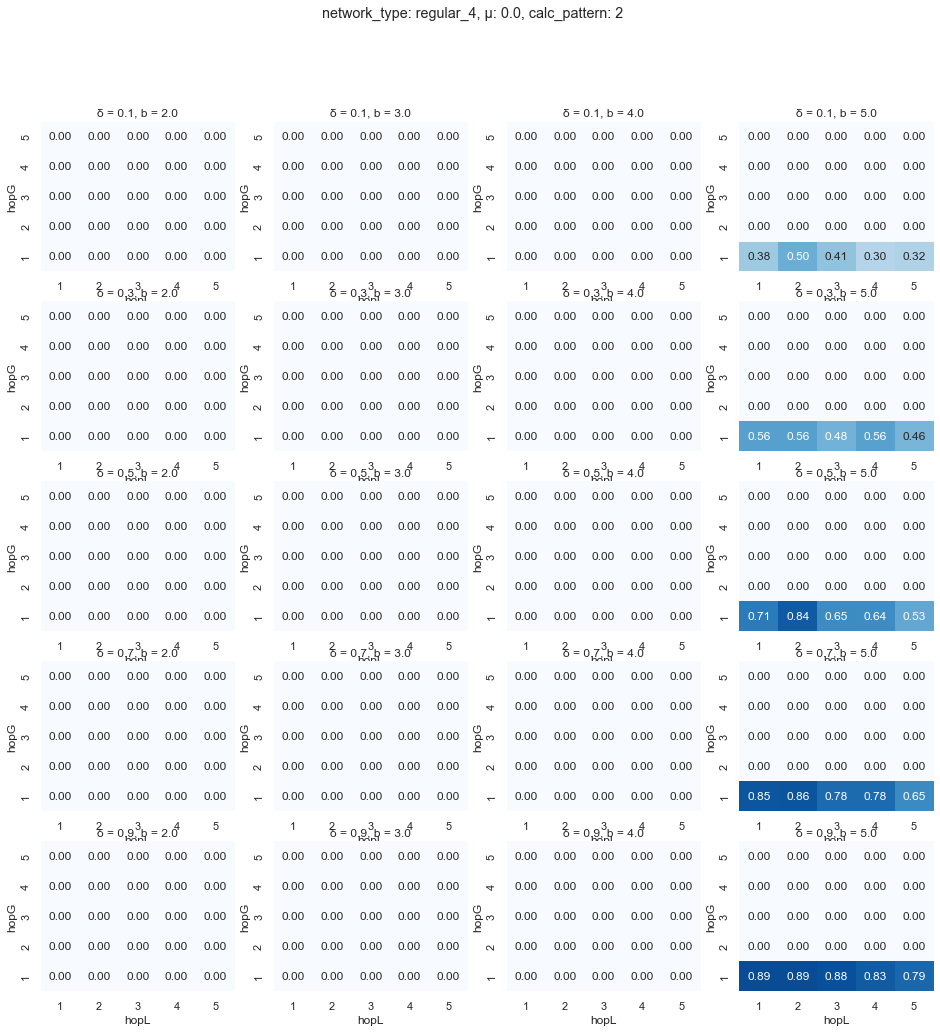

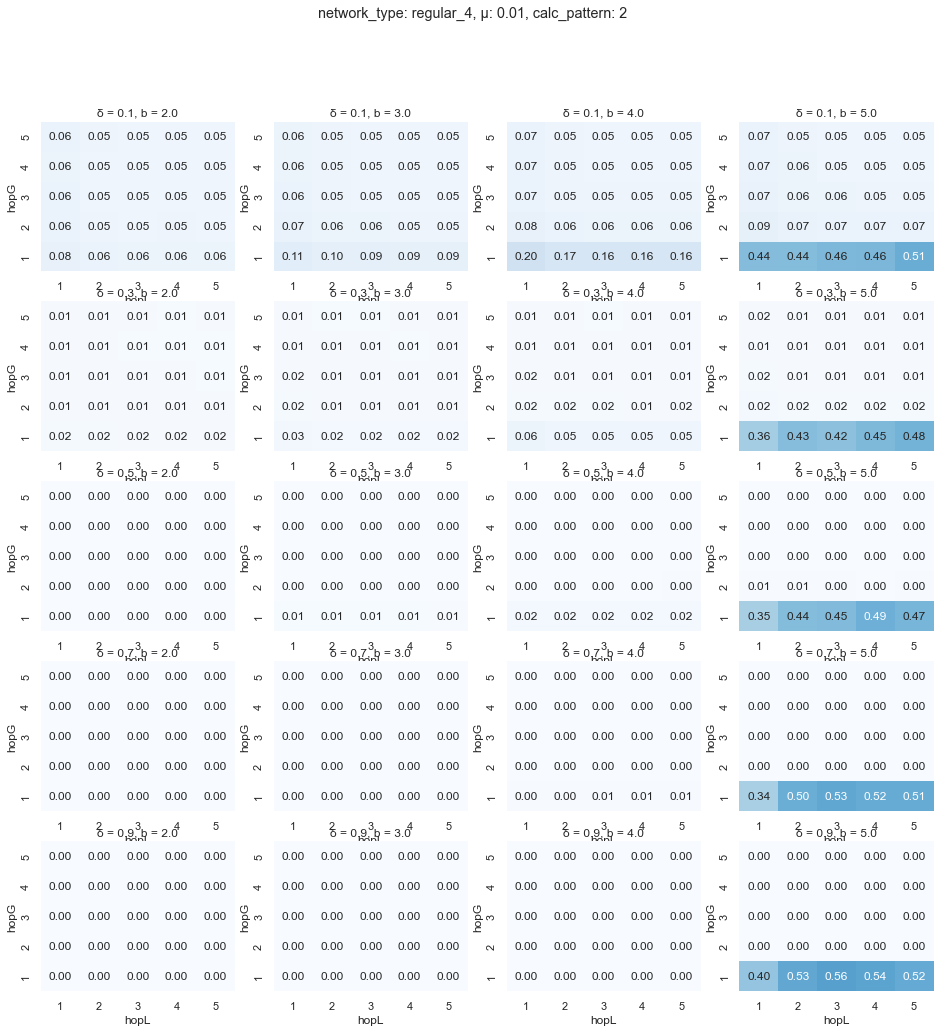

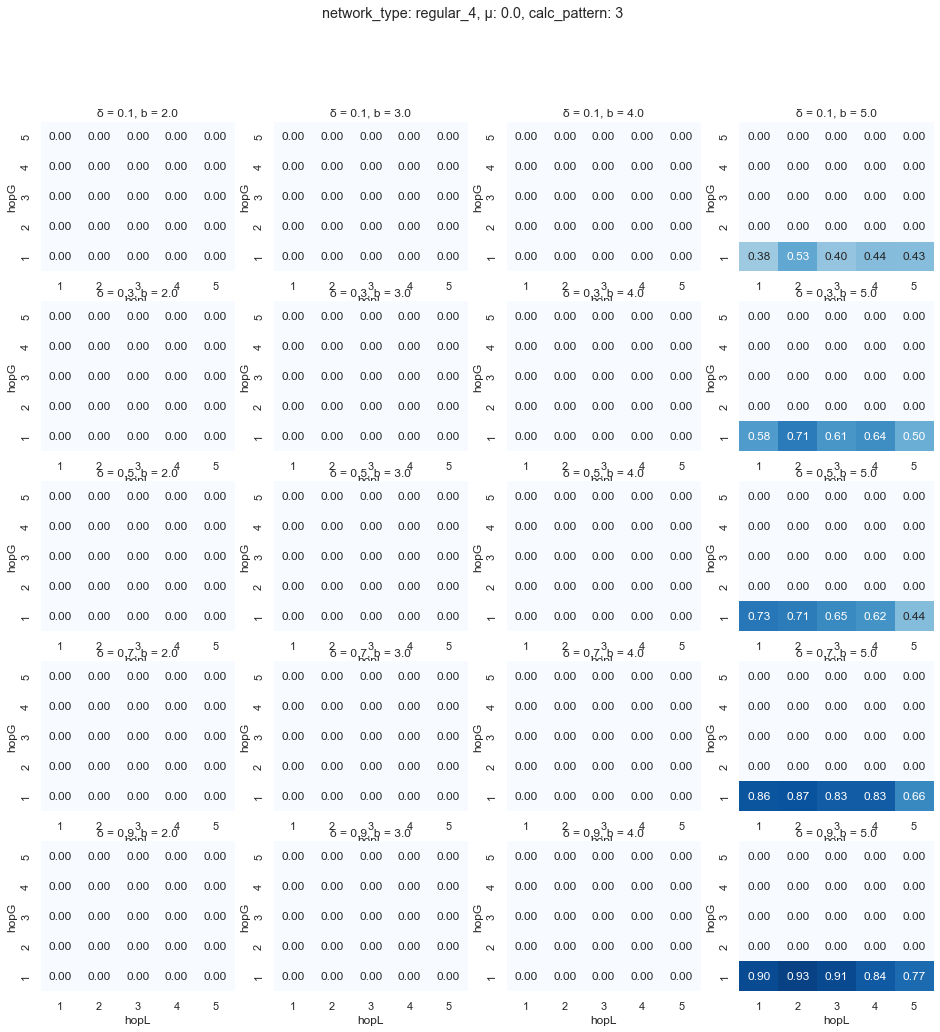

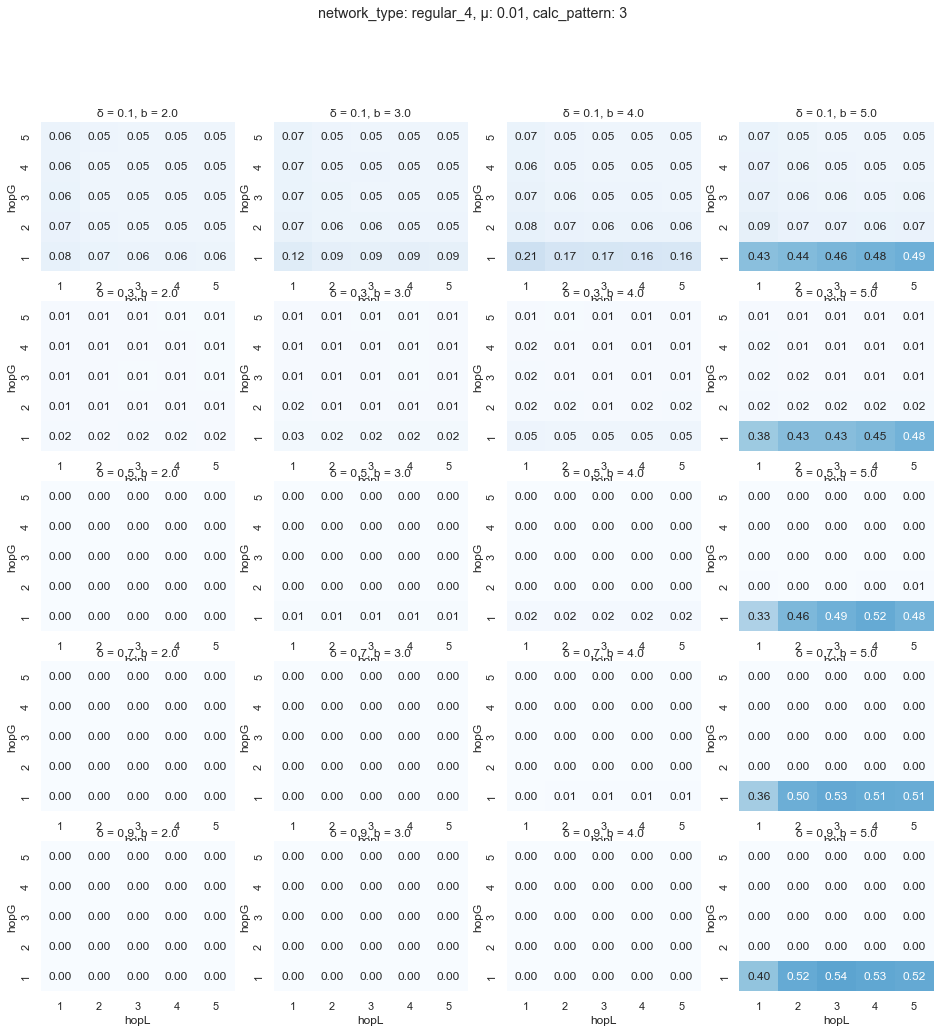

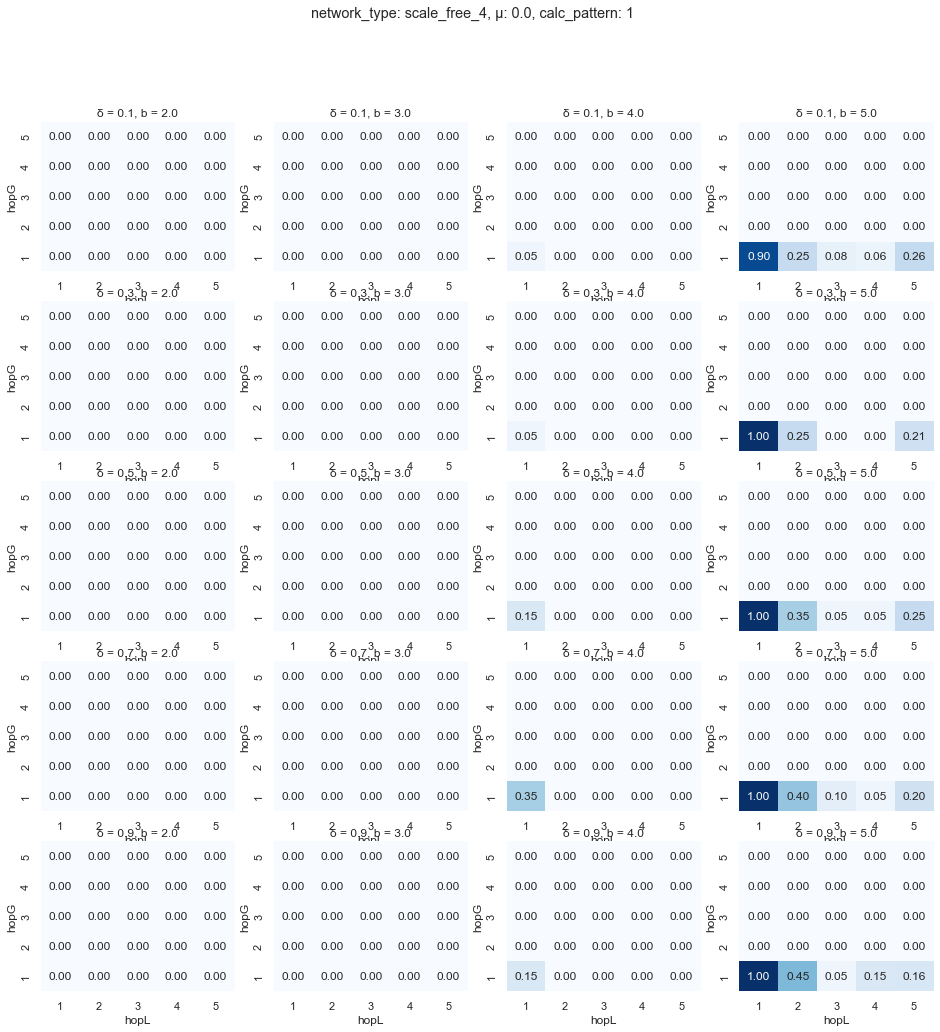

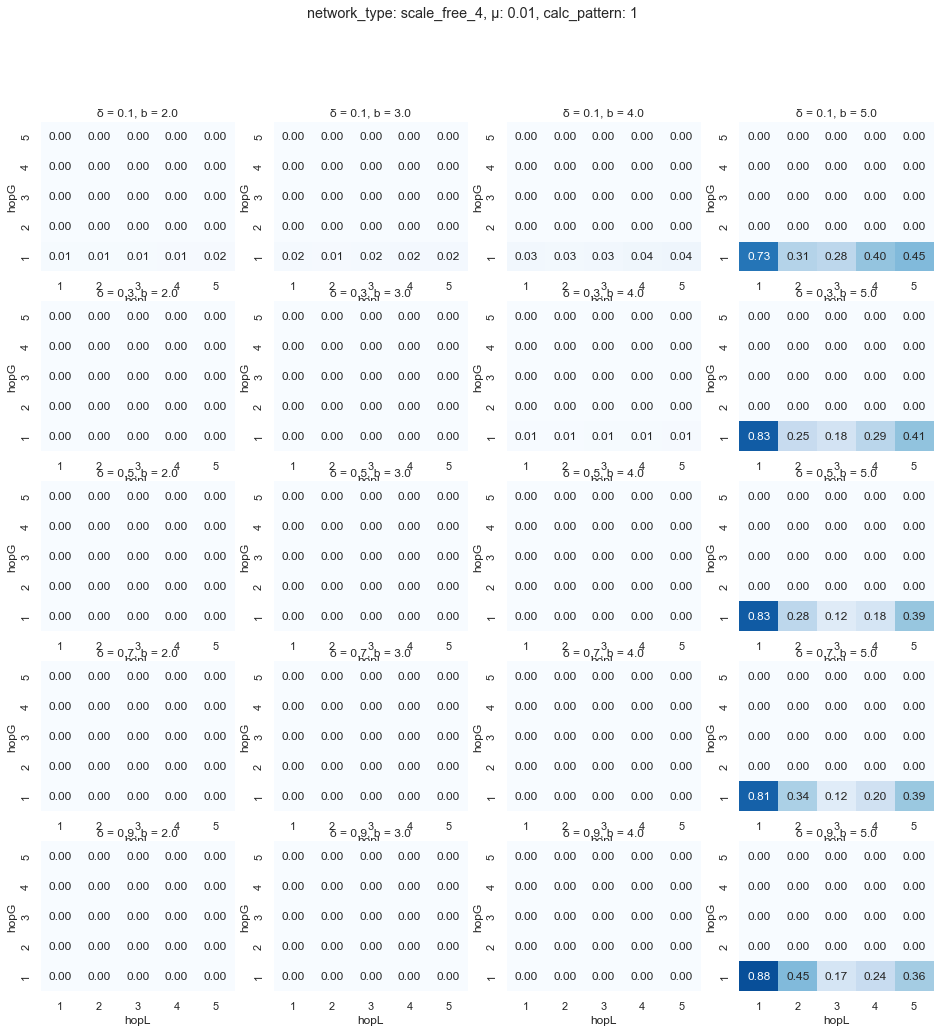

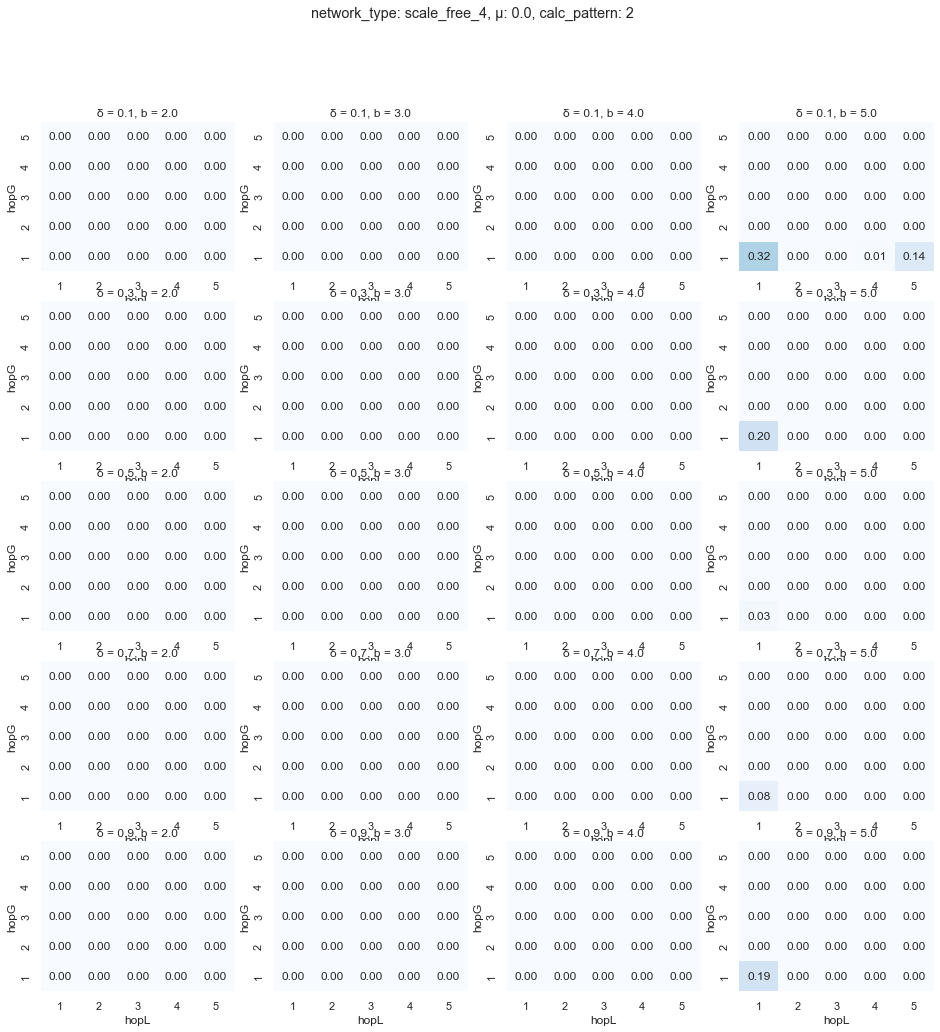

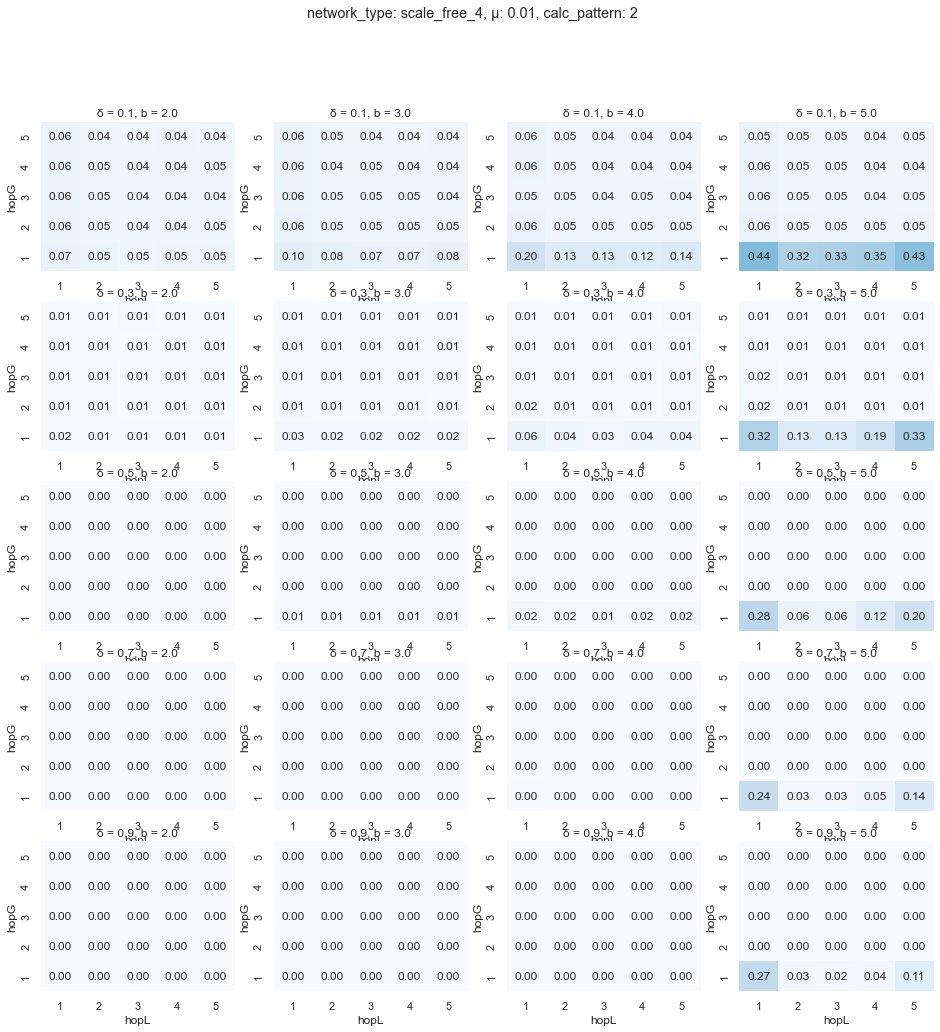

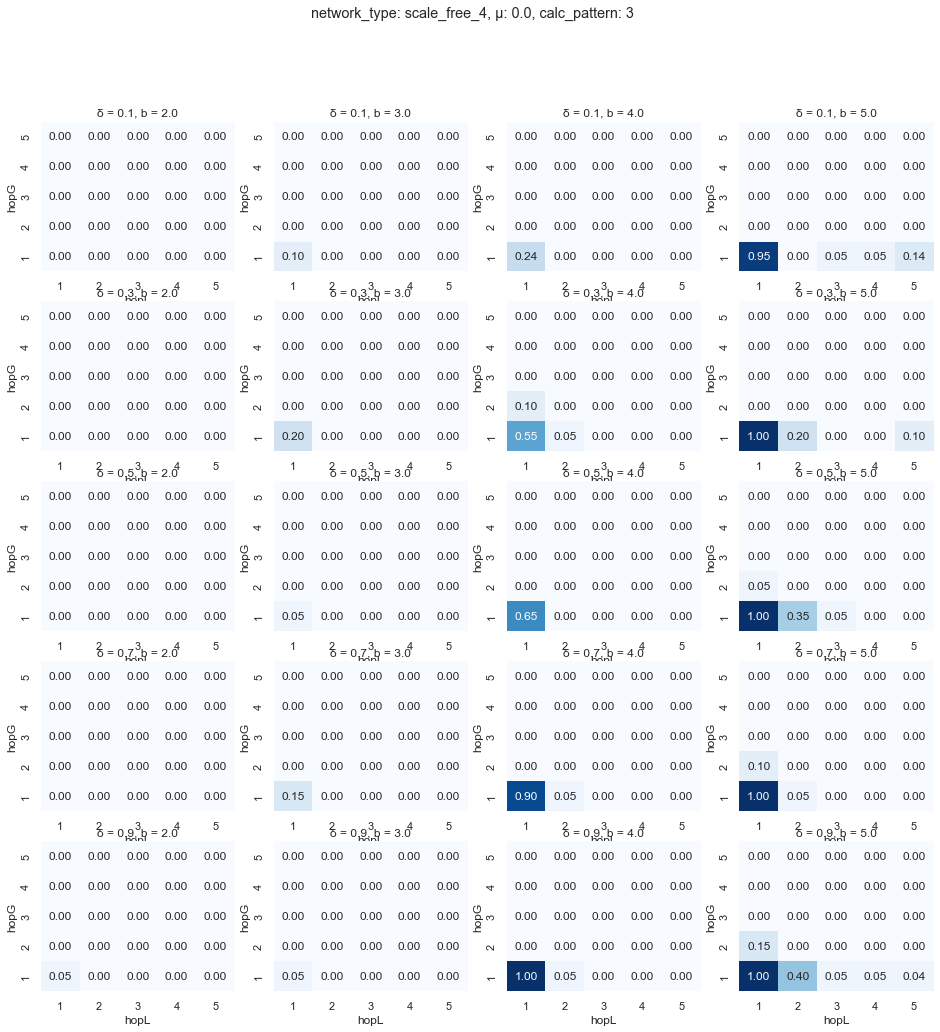

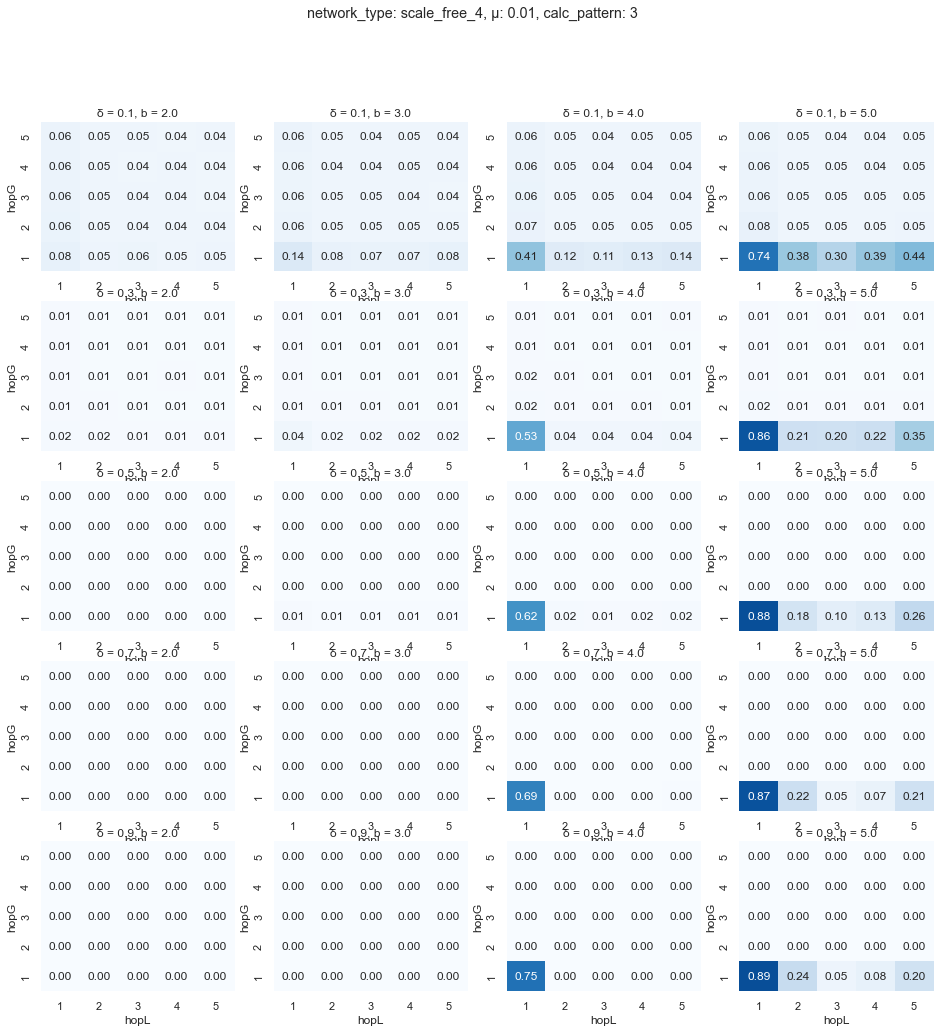

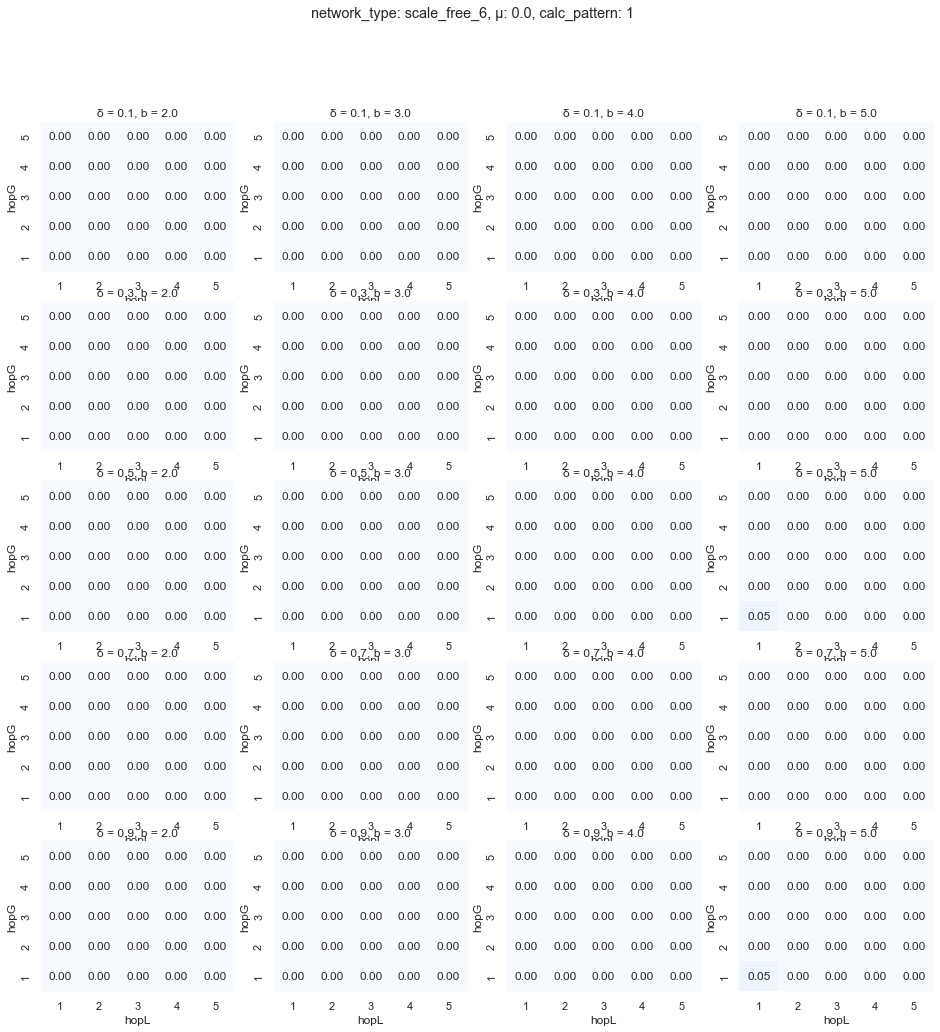

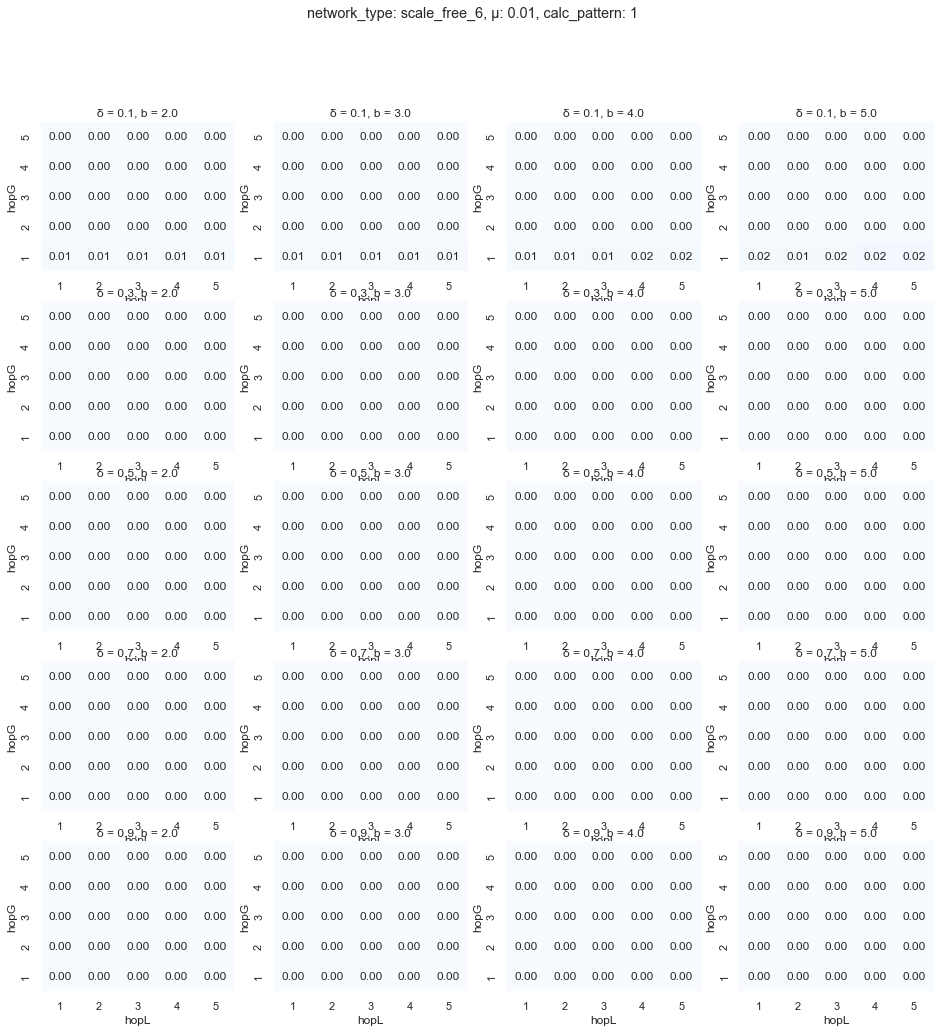

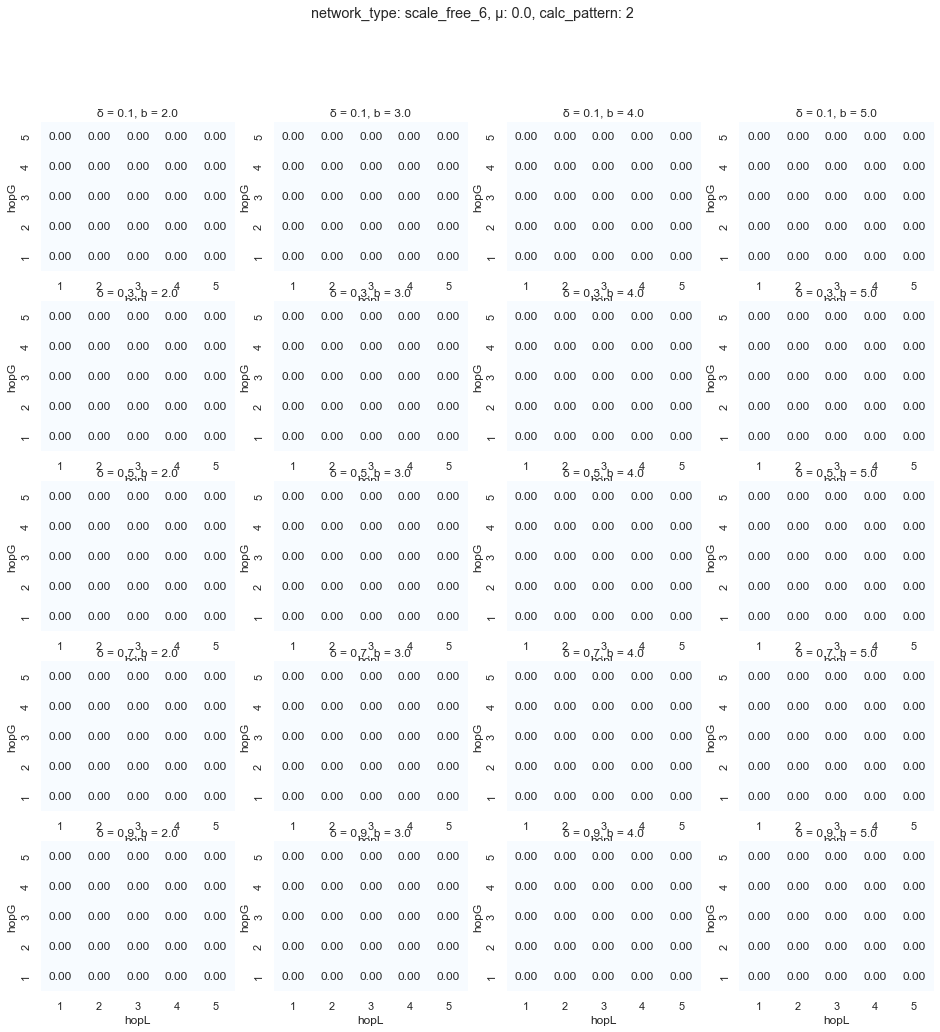

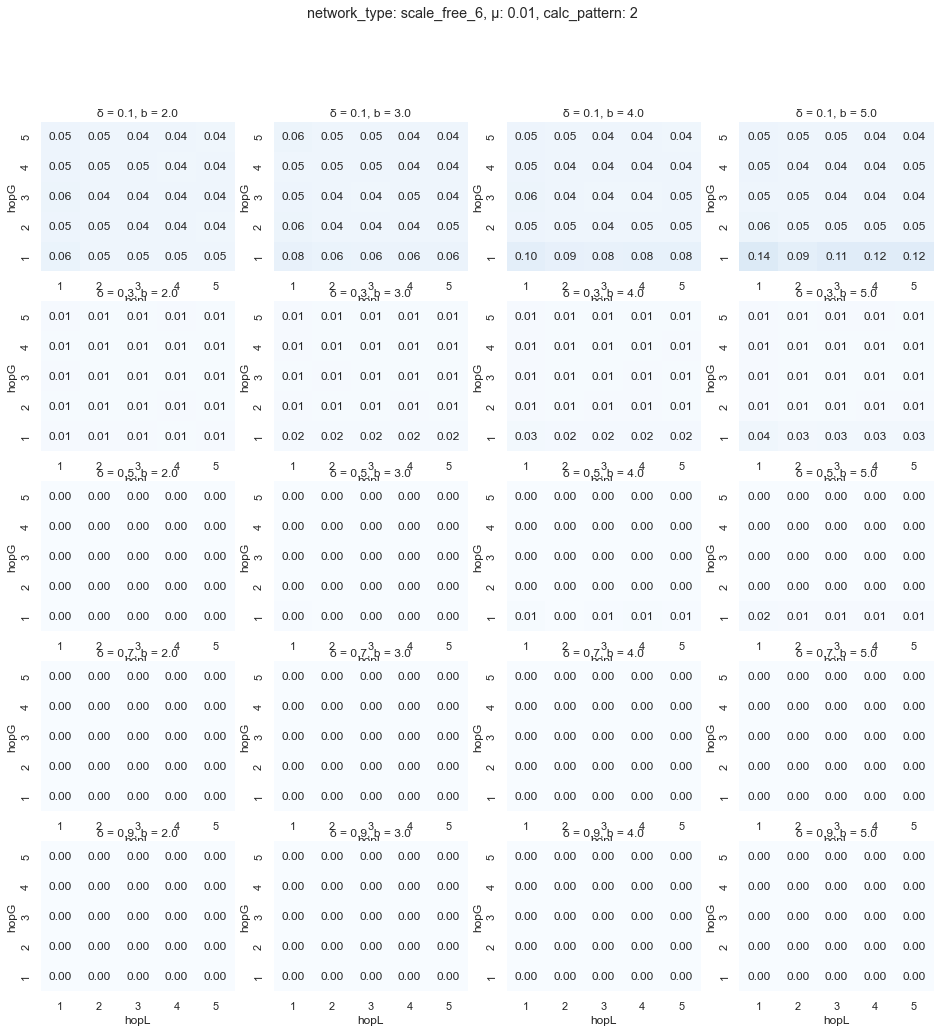

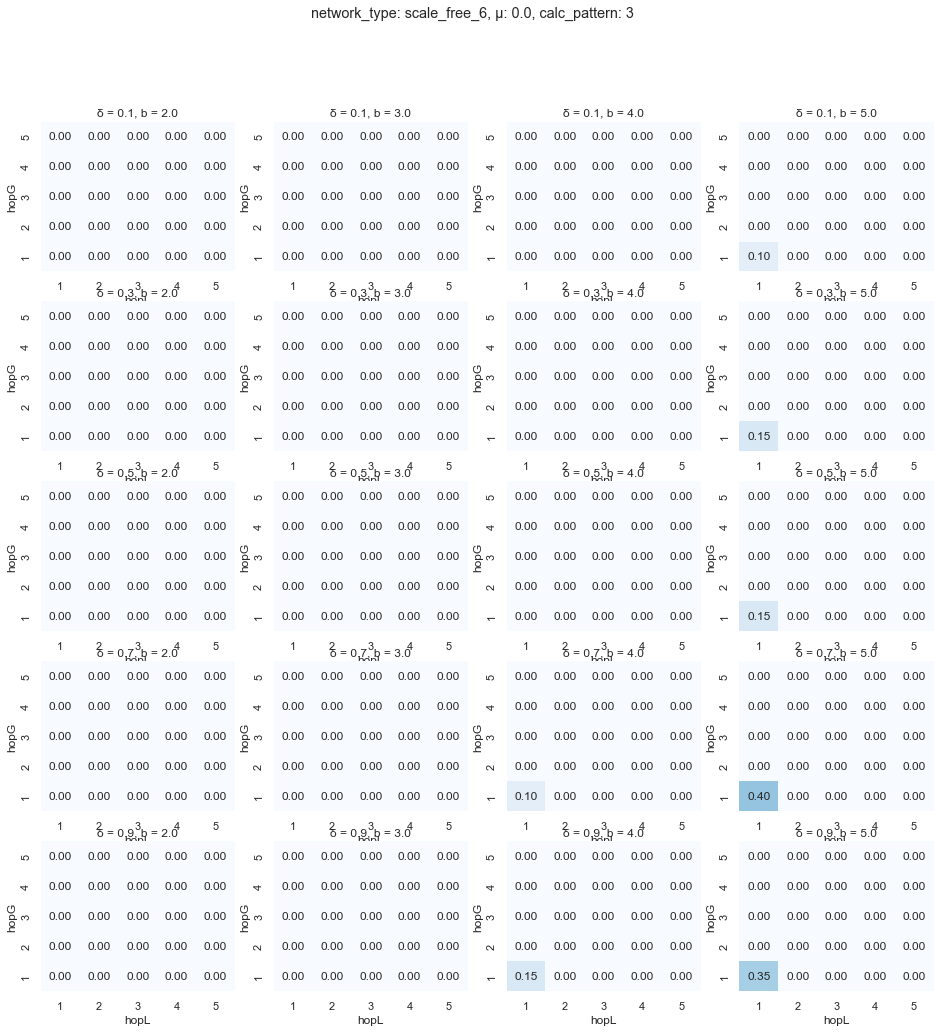

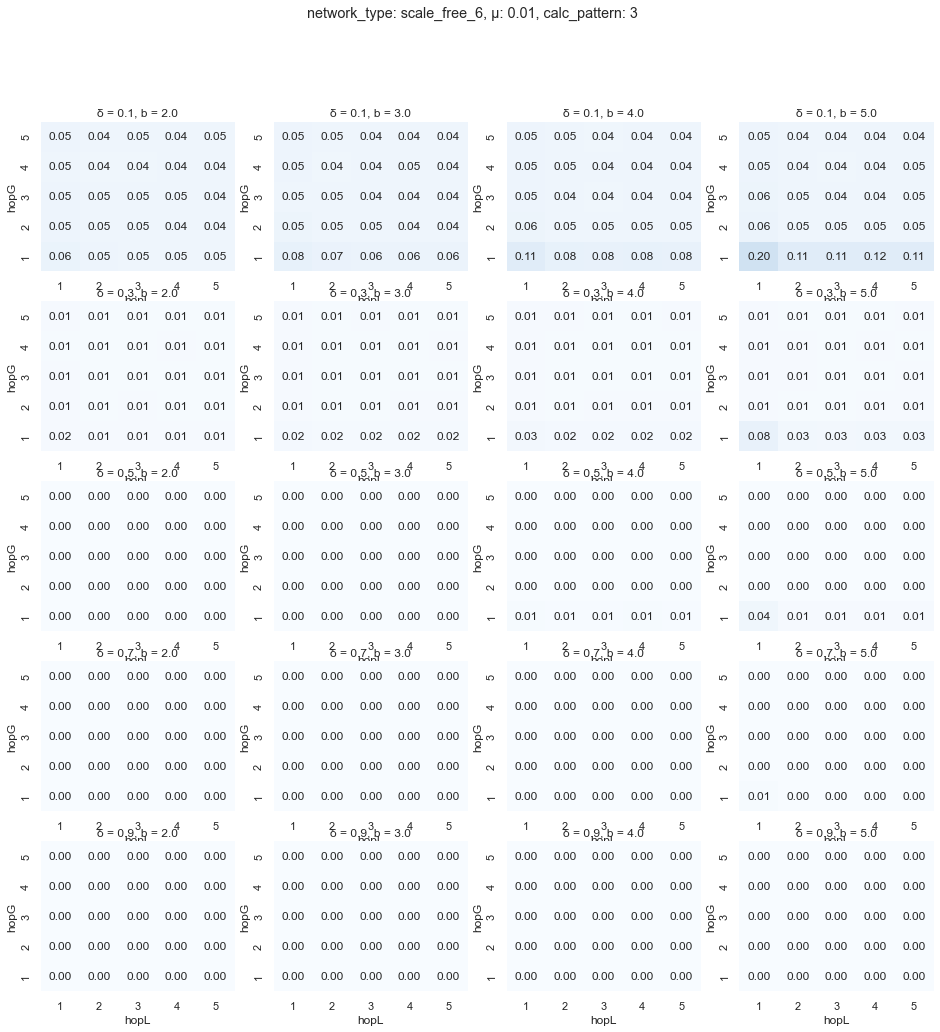

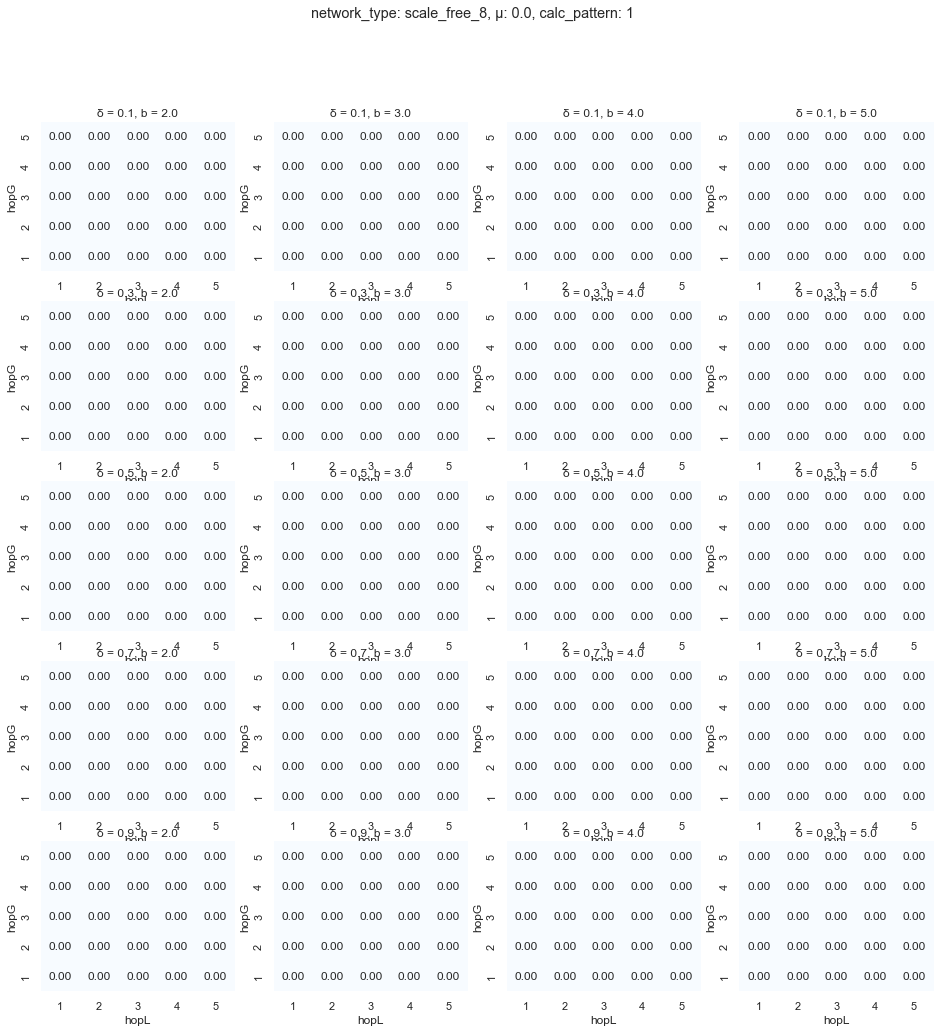

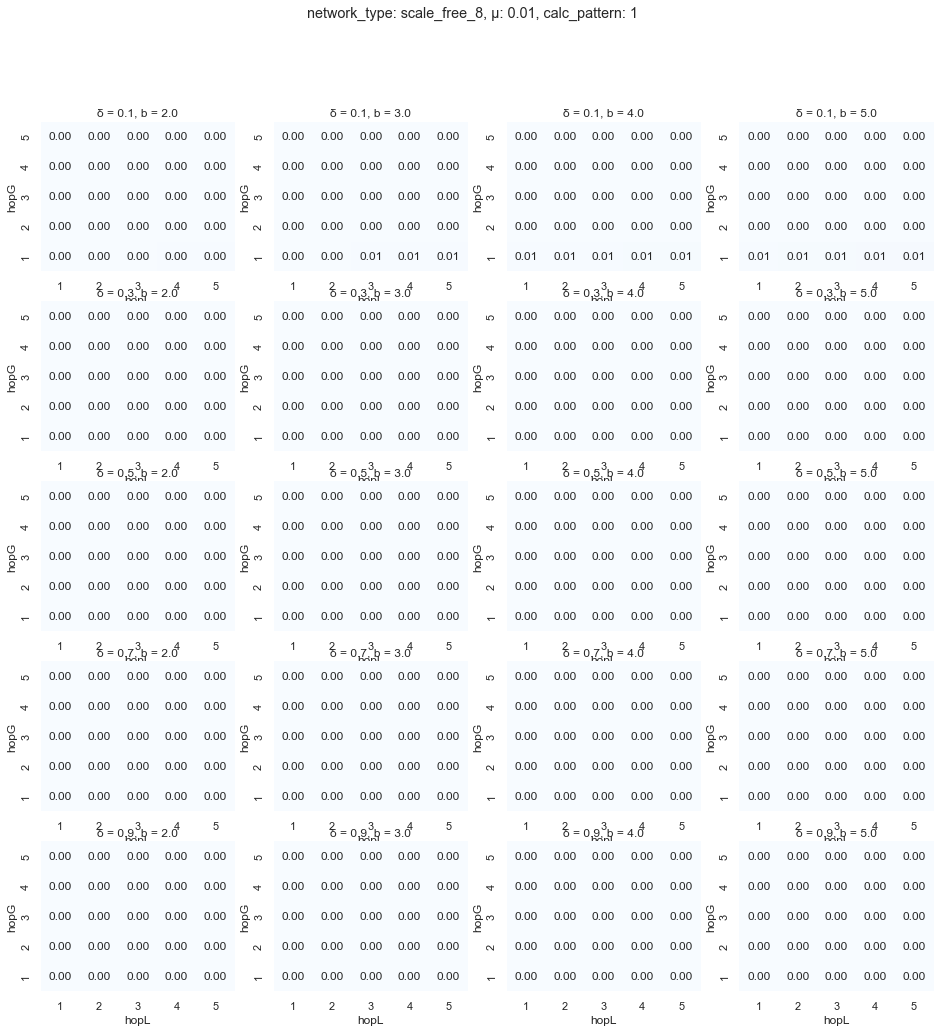

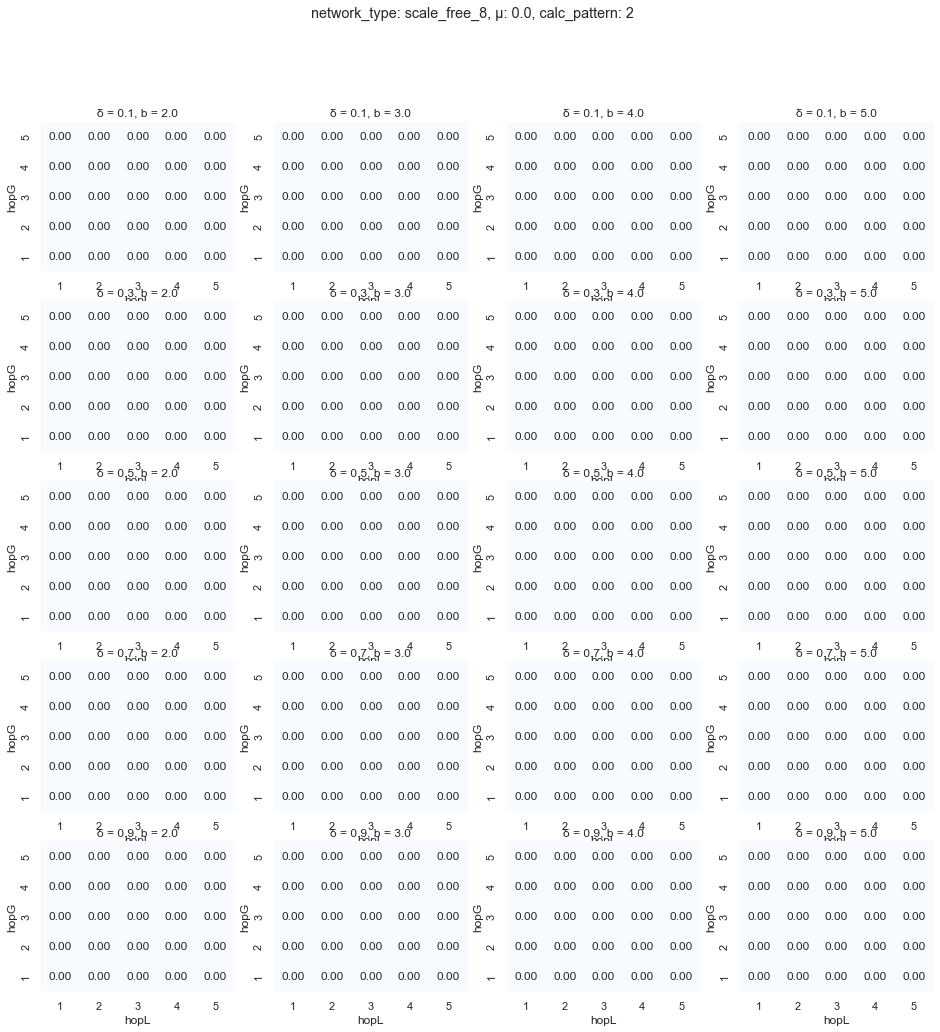

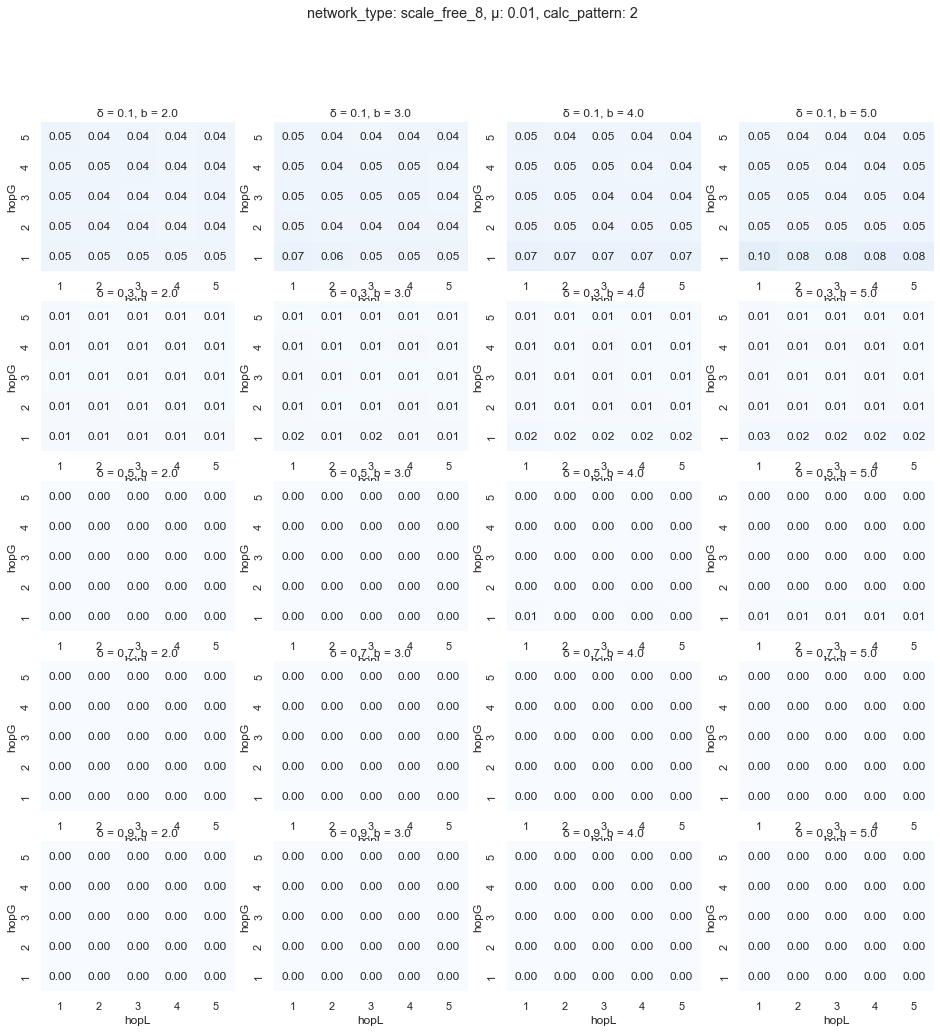

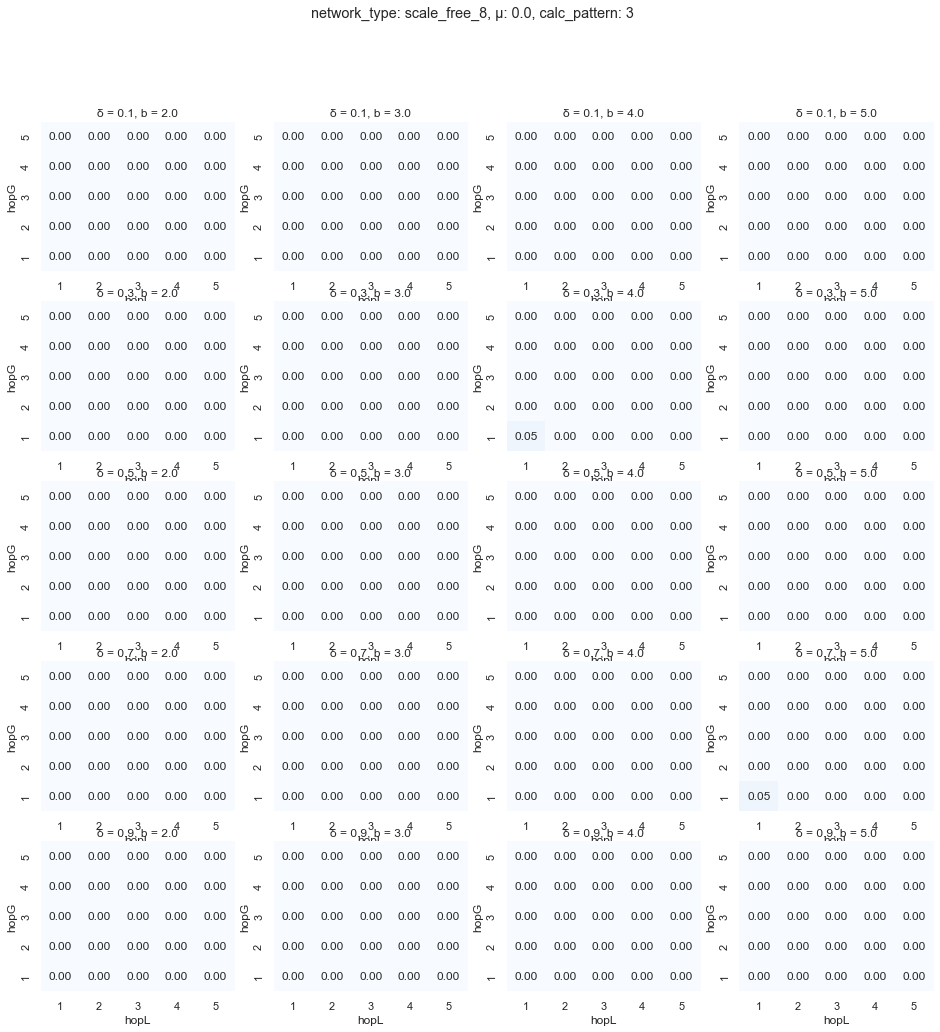

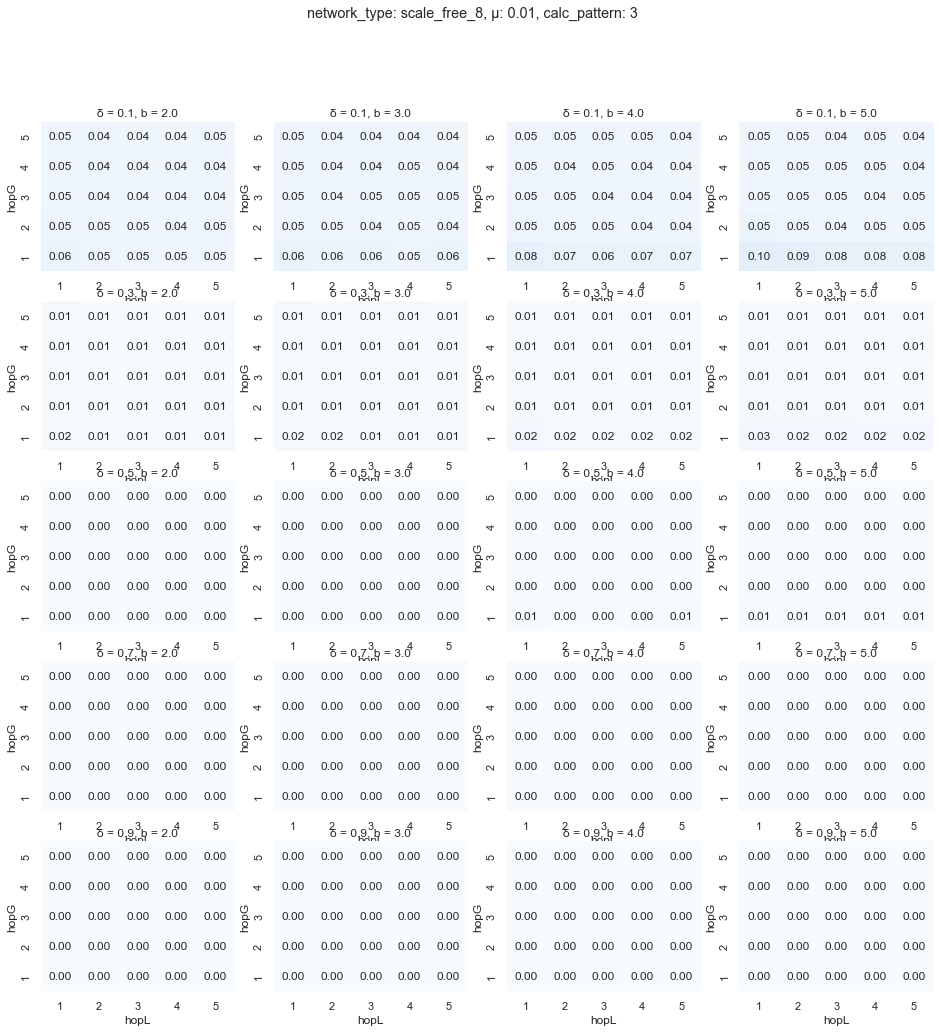

In [25]:
for (_, network_type, μ, calc_pattern) in df_weak_selection[['network_type', 'μ', 'calc_pattern']].drop_duplicates().itertuples():
    _df = filter_by_criteria(df_weak_selection, network_type, μ, calc_pattern)
    δ_list = list(_df.δ.unique())
    b_list = list(_df.b.unique())
    fig, axes = plt.subplots(nrows=len(δ_list), ncols=len(b_list), figsize=(16, 16))
    fig_title = 'network_type: {}, μ: {}, calc_pattern: {}'.format(network_type, μ, calc_pattern)
    print(fig_title)
    fig.suptitle(fig_title)

    for x, b in enumerate(b_list):
        for y, δ in enumerate(δ_list):
            __df = _df[(_df.b == b) & (_df.δ == δ)][['hop_game', 'hop_learning', 'cooperator_rate']].reset_index(drop=True)
            __df = pibot_by_hop(__df)
            sns.heatmap(__df, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1, cbar=False, ax=axes[y, x])
            axes[y, x].set_title('δ = {}, b = {}'.format(δ, b))
            axes[y, x].set_xlabel('hopL')
            axes[y, x].set_ylabel('hopG')

network_type: random_4, μ: 0.0, calc_pattern: 1
network_type: random_4, μ: 0.01, calc_pattern: 1
network_type: random_4, μ: 0.0, calc_pattern: 2
network_type: random_4, μ: 0.01, calc_pattern: 2
network_type: random_4, μ: 0.0, calc_pattern: 3
network_type: random_4, μ: 0.01, calc_pattern: 3
network_type: regular_4, μ: 0.0, calc_pattern: 1
network_type: regular_4, μ: 0.01, calc_pattern: 1
network_type: regular_4, μ: 0.0, calc_pattern: 2
network_type: regular_4, μ: 0.01, calc_pattern: 2
network_type: regular_4, μ: 0.0, calc_pattern: 3
network_type: regular_4, μ: 0.01, calc_pattern: 3
network_type: scale_free_4, μ: 0.0, calc_pattern: 1
network_type: scale_free_4, μ: 0.01, calc_pattern: 1
network_type: scale_free_4, μ: 0.0, calc_pattern: 2
network_type: scale_free_4, μ: 0.01, calc_pattern: 2
network_type: scale_free_4, μ: 0.0, calc_pattern: 3
network_type: scale_free_4, μ: 0.01, calc_pattern: 3
network_type: scale_free_6, μ: 0.0, calc_pattern: 1
network_type: scale_free_6, μ: 0.01, calc_pat

/var/folders/p1/637brbmn7c39lv4lj085k_8h0000gn/T/ipykernel_7489/1022107867.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrows=1, ncols=len(b_list), figsize=(16, 4))


network_type: scale_free_6, μ: 0.0, calc_pattern: 2
network_type: scale_free_6, μ: 0.01, calc_pattern: 2
network_type: scale_free_6, μ: 0.0, calc_pattern: 3
network_type: scale_free_6, μ: 0.01, calc_pattern: 3
network_type: scale_free_8, μ: 0.0, calc_pattern: 1
network_type: scale_free_8, μ: 0.01, calc_pattern: 1
network_type: scale_free_8, μ: 0.0, calc_pattern: 2
network_type: scale_free_8, μ: 0.01, calc_pattern: 2
network_type: scale_free_8, μ: 0.0, calc_pattern: 3
network_type: scale_free_8, μ: 0.01, calc_pattern: 3


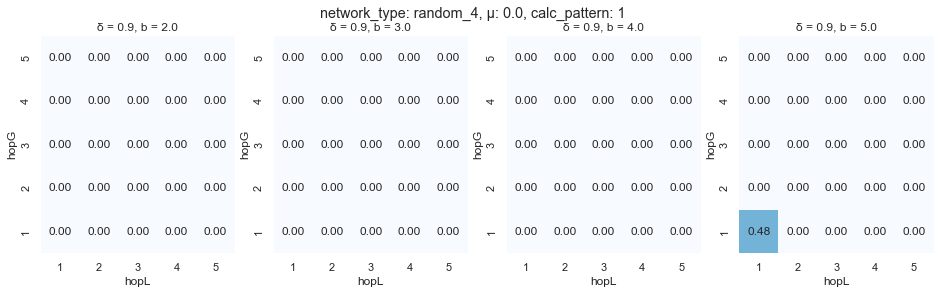

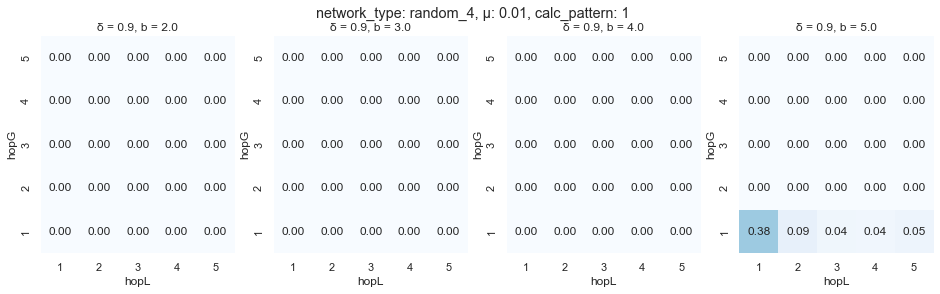

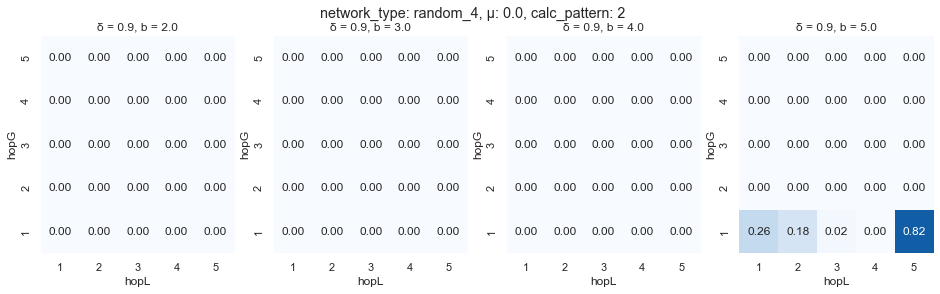

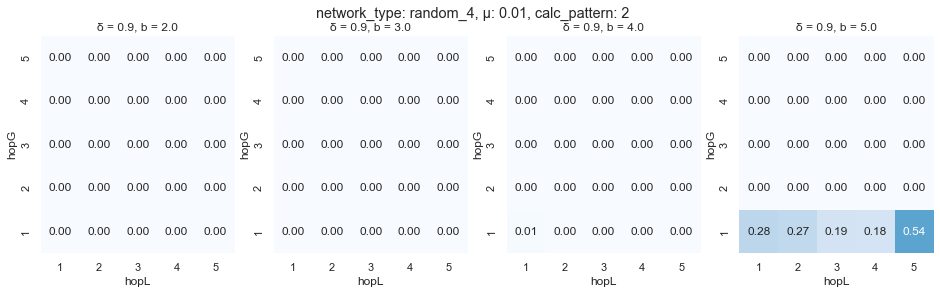

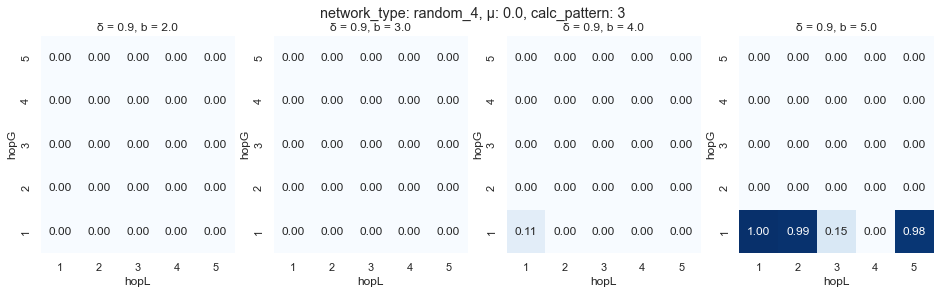

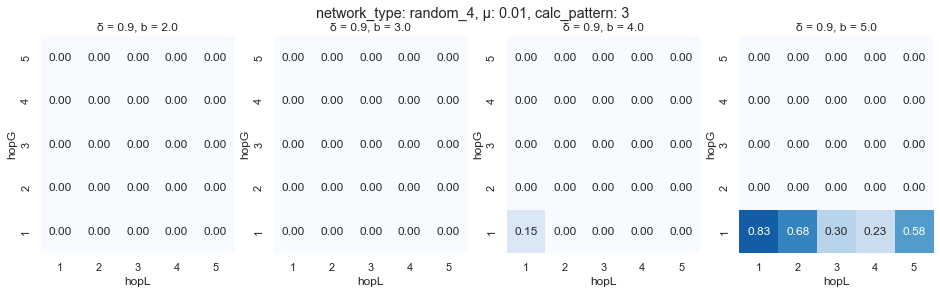

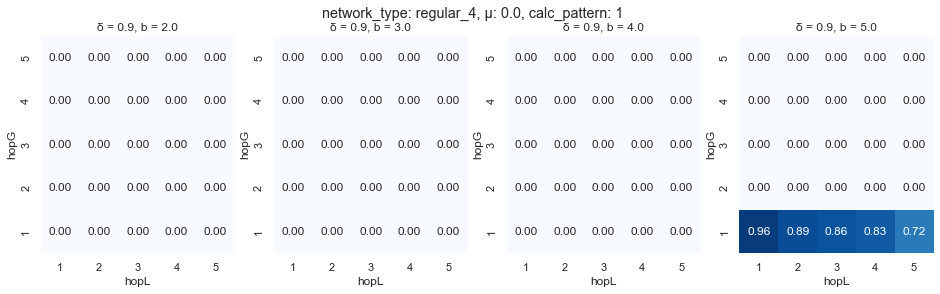

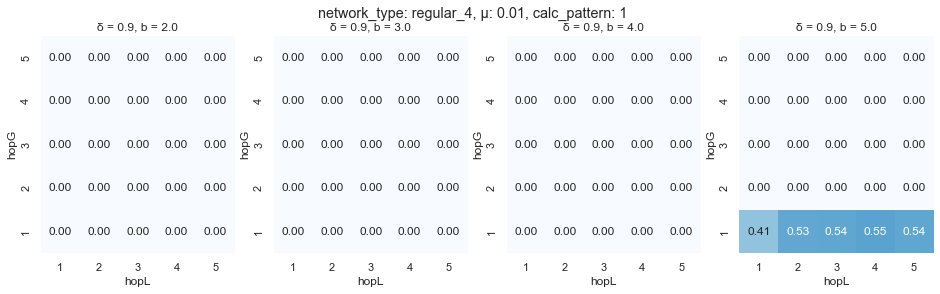

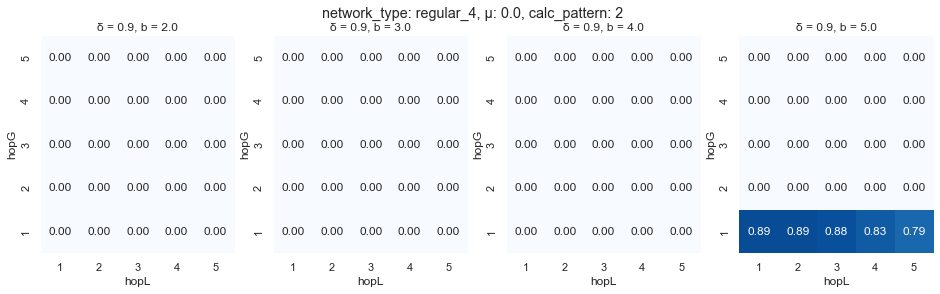

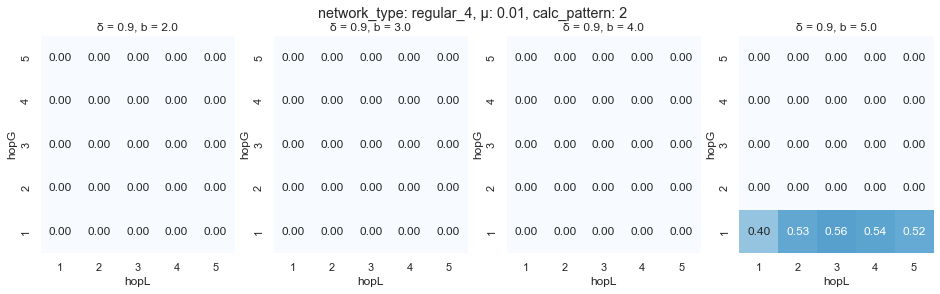

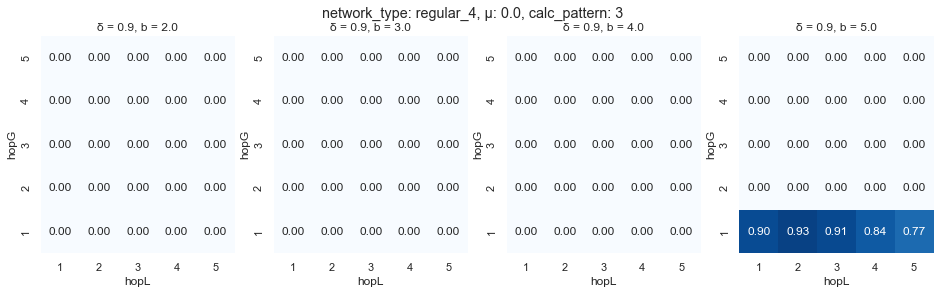

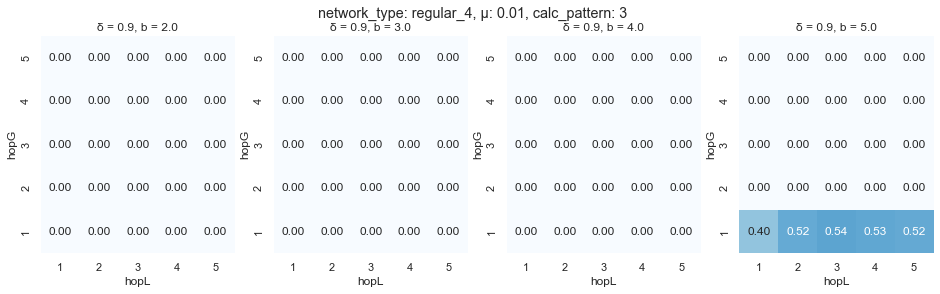

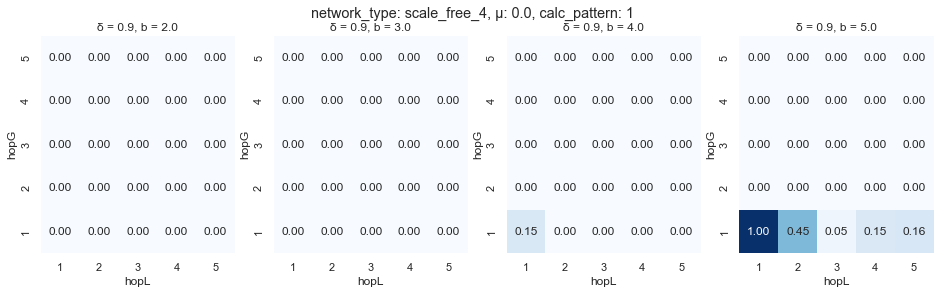

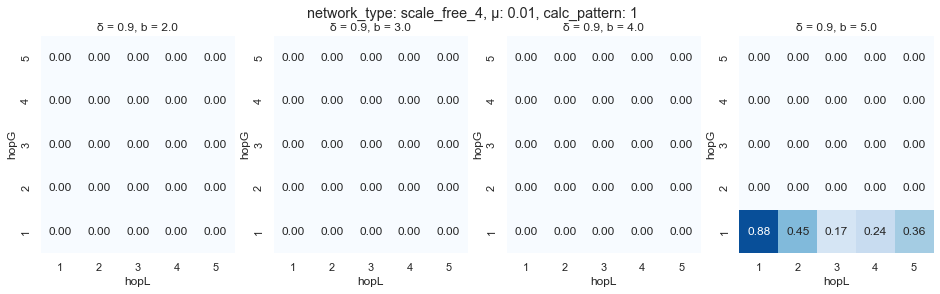

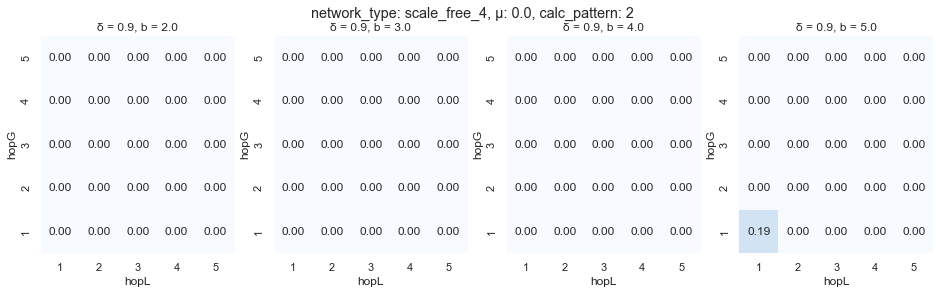

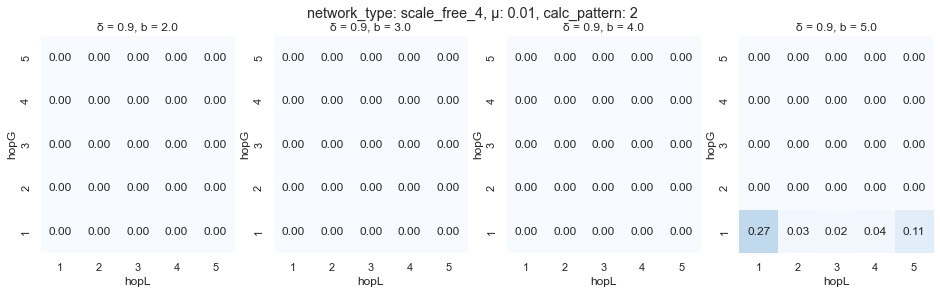

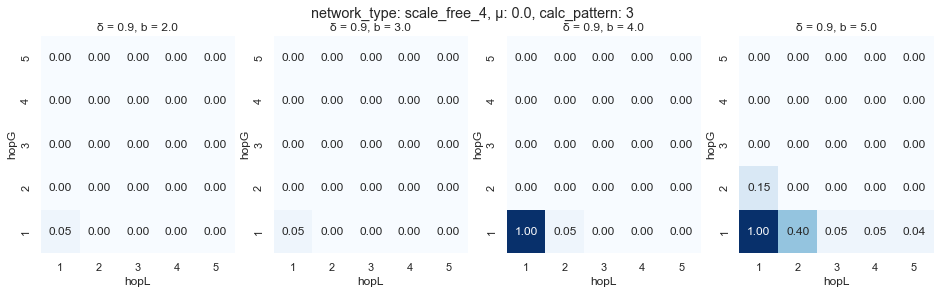

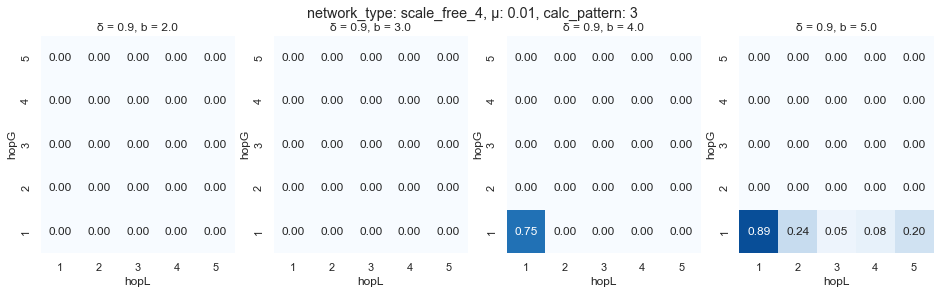

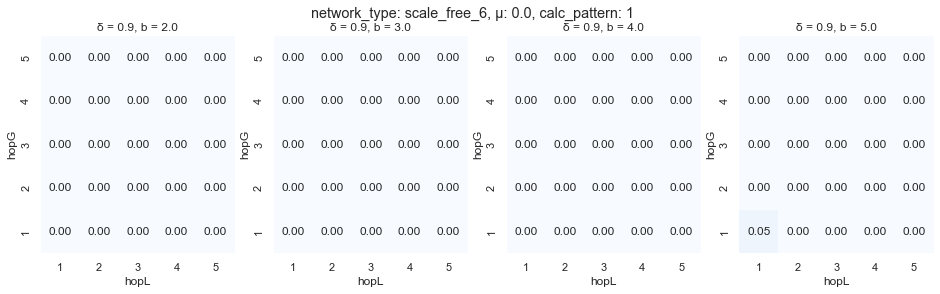

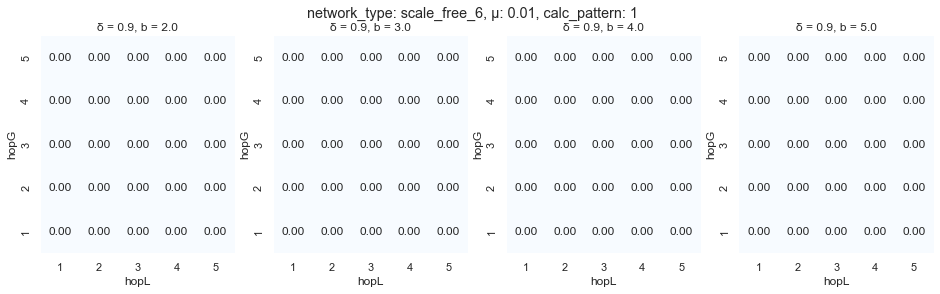

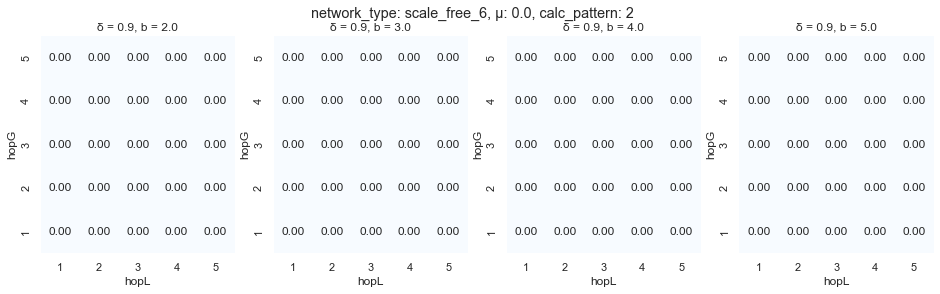

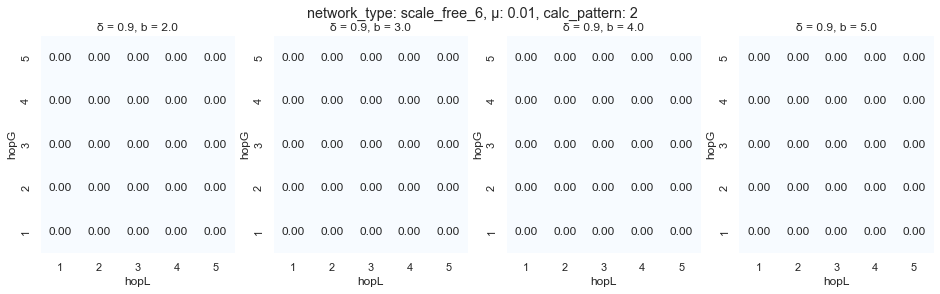

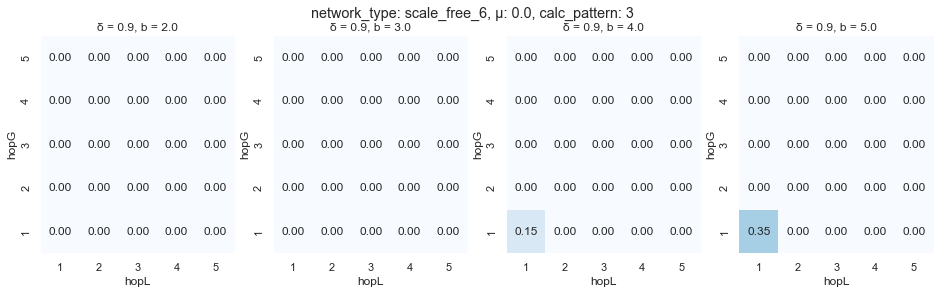

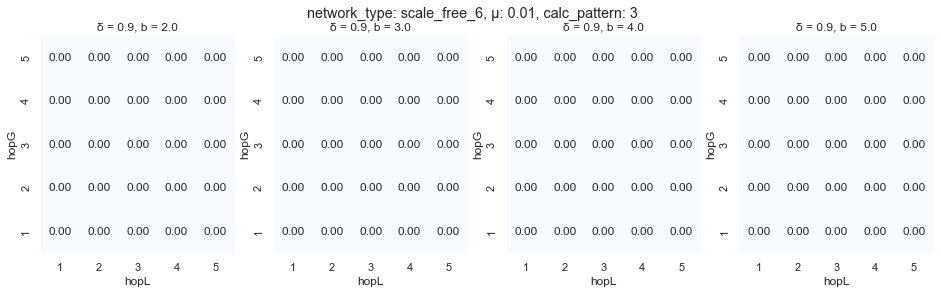

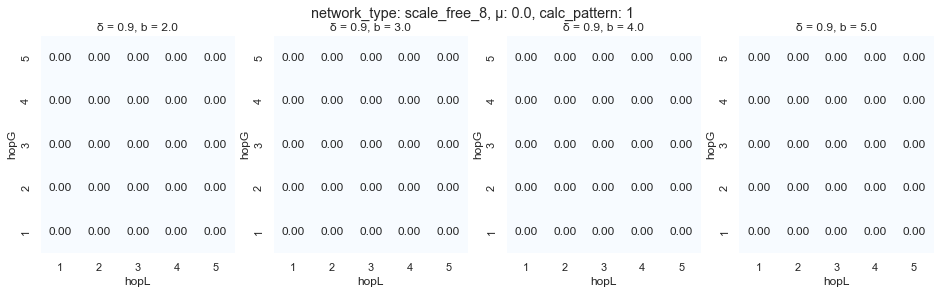

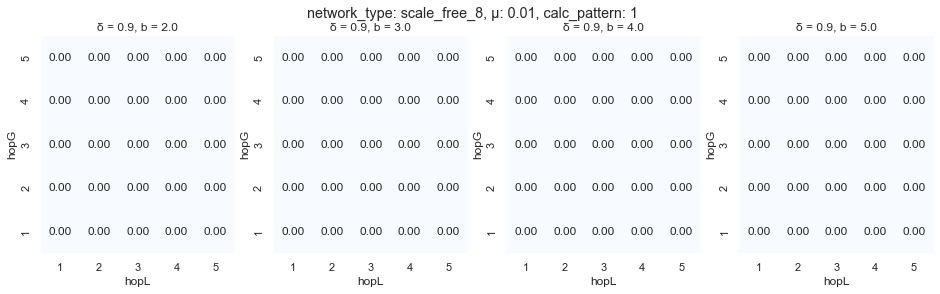

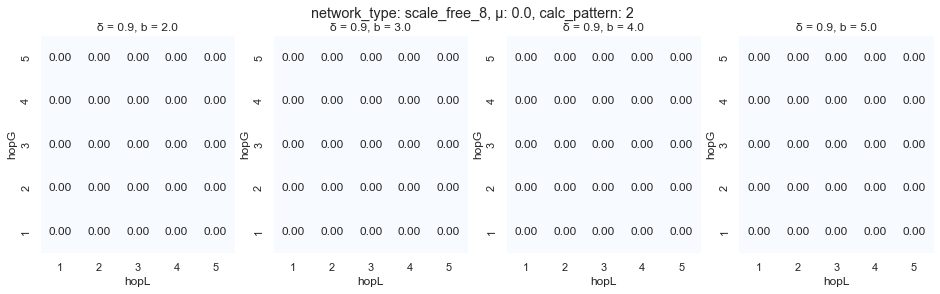

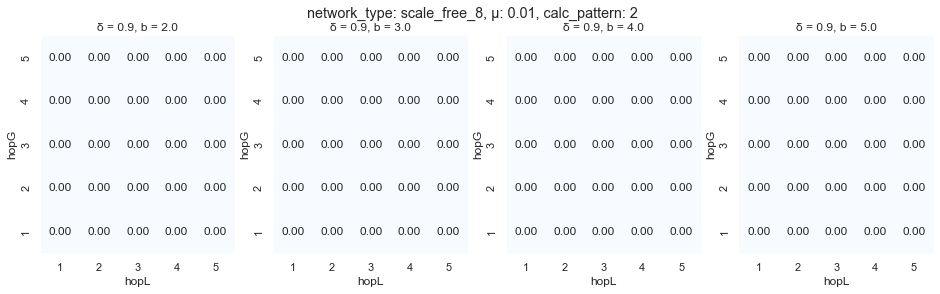

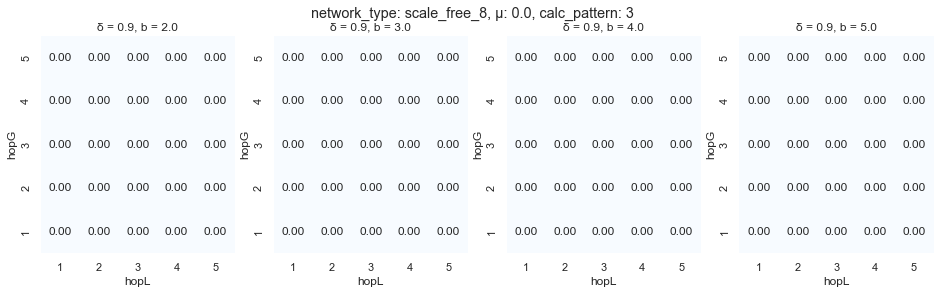

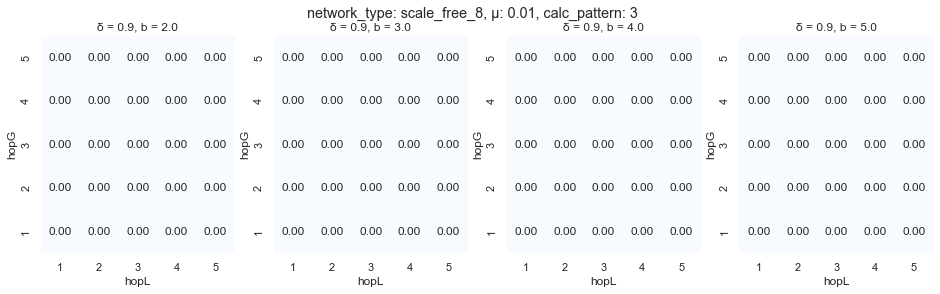

In [28]:
for (_, network_type, μ, calc_pattern) in df_weak_selection[['network_type', 'μ', 'calc_pattern']].drop_duplicates().itertuples():
    _df = filter_by_criteria(df_weak_selection, network_type, μ, calc_pattern)
    b_list = list(_df.b.unique())
    fig, axes = plt.subplots(nrows=1, ncols=len(b_list), figsize=(16, 4))
    fig_title = 'network_type: {}, μ: {}, calc_pattern: {}'.format(network_type, μ, calc_pattern)
    print(fig_title)
    fig.suptitle(fig_title)

    for x, b in enumerate(b_list):
        __df = _df[(_df.b == b) & (_df.δ == δ)][['hop_game', 'hop_learning', 'cooperator_rate']].reset_index(drop=True)
        __df = pibot_by_hop(__df)
        sns.heatmap(__df, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1, cbar=False, ax=axes[x])
        axes[x].set_title('δ = {}, b = {}'.format(δ, b))
        axes[x].set_xlabel('hopL')
        axes[x].set_ylabel('hopG')